<br>

# static FC 데이터로 Cognitvie Ability 예측하기

<br>

* Korea Brain Research Institute, Cognitive Science Research Group, Deep Memory Lab
* by THK. 2020년 11월 29일 

<br>

* fMRI functional connectivity 데이터를 활용한 인지 기능, 스트레스, 불안 정도의 예측 모델링 연구를 위한 예비 분석으로 sFC 데이터와 인지 기능 측정치 간의 관계를 모델링해본다.
* 공개된 HCP 데이터와 원내에서 수집된 Sustained attention 데이터를 활용. connectome based predictive modeling과 간단한 선형 관계 검증을 수행한다.

---


# Setting

<br>

---


In [1]:
from sys import executable
print(executable)

/Users/taehoonkim/miniforge3/envs/th/bin/python


In [2]:
# utility
import os
from copy import deepcopy
import warnings

# data handling
import pandas as pd
import numpy as np
import missingno as msno

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# statistics
import scipy as sp
from scipy import stats
import pingouin as pg

# modeling
import sklearn

In [3]:
# plotting setting
from IPython.core.display import display, HTML
from IPython.display import Image
plt.style.use('seaborn')  # plt.style.use('ggplot')
sns.set(font_scale=1.5)

plt.rc('font', family='AppleGothic') # For Windows
plt.rcParams['figure.figsize'] = [10, 5]
mpl.rcParams['axes.unicode_minus'] = False

%matplotlib inline

# ignore warnings
warnings.filterwarnings('ignore')

---

# dataset

<br>

---

## HCP, CPM dataset

* Human Connectome Project의 n = 337명 참가자에 대한 fc 데이터와 여러 task로 측정한 행동 데이터가 포함되어 있음.
* sFC 매트릭스 정보를 통해 참가자의 cognitive variabel을 예측하는 Connectome-based predictive Modeling을 수행하였음.

<br>

* fMRI fc 데이터는 Shen 268 atlas에서 추출되었으며, 총 5개의 상태 각각에서 획득되었음.
    * Rest (REST)
    * Working memory (WM)
    * Language (LANGUAGE)
    * Gambling (GAMBLING)
    * Social (SOCIAL)
    
<br>    
    
* behavior Task 데이터는 총 7개 과제 각각에서 획득되었음.
    * PMAT24_A_CR: Fluid intelligence (# items correct on Raven's progressive matrices task)
    * ListSort_Unadj: Working memory (list sorting task)
    * PicVocab_Unadj: Picture vocabulary (verbal IQ)
    * ReadEng_Unadj: Reading (verbal IQ)
    * ProcSpeed_Unadj: Processing speed
    * PicSeq_Unadj: Episodic memory (picture sequence)
    * DDisc_AUC_40K: Measure of delay discounting
    
<br>

* Reference
    * Barch, D. M., Burgess, G. C., Harms, M. P., Petersen, S. E., Schlaggar, B. L., Corbetta, M., ... & Van Essen, D. C. (2013). Function in the human connectome: task-fMRI and individual differences in behavior. Neuroimage, 80, 169-189.
    * https://github.com/esfinn/cpm_tutorial
    * Finn ES, Shen X, Scheinost D, Rosenberg MD, Huang J, Chun MM, Papademetris X, Constable RT. (2015) Functional connectome fingerprinting: Identifying individuals using patterns of brain connectivity. Nature Neuroscience, 18: 1664–1671.
    * Shen X, Finn ES, Scheinost D, Rosenberg MD, Chun MM, Papademetris X, Constable RT. (2017). Using connectome-based predictive modeling to predict individual behavior from brain connectivity. Nature Protocols 12: 506-18.

## KBRI, susATT dataset

* 12명의 참가자(sn2~13) 대상, resting state & task state fMRI 스캔 진행
* task state에는 참가자의 sustained attention 능력 측정을 위해 Gradual-onset continuous performance task(gradCPT) 진행
* resting-state, task-state의 static Functional Connect와 gradCPT의 Attention 능력 측정치(d-prime)를 획득.
* shen 268 brain parcells 활용. 268개 뇌 영역에서 rs-sFC, tb-sFC 를 계산, sFC 매트릭스를 구성
* sFC 매트릭스 정보를 통해 참가자의 d-prime을 예측하는 Connectome-based predictive Modeling을 수행하였음

## Shen 268 Atlas

* Shen 268 brain parcels [[atlas]](https://www.nitrc.org/frs/?group_id=51)

<br>

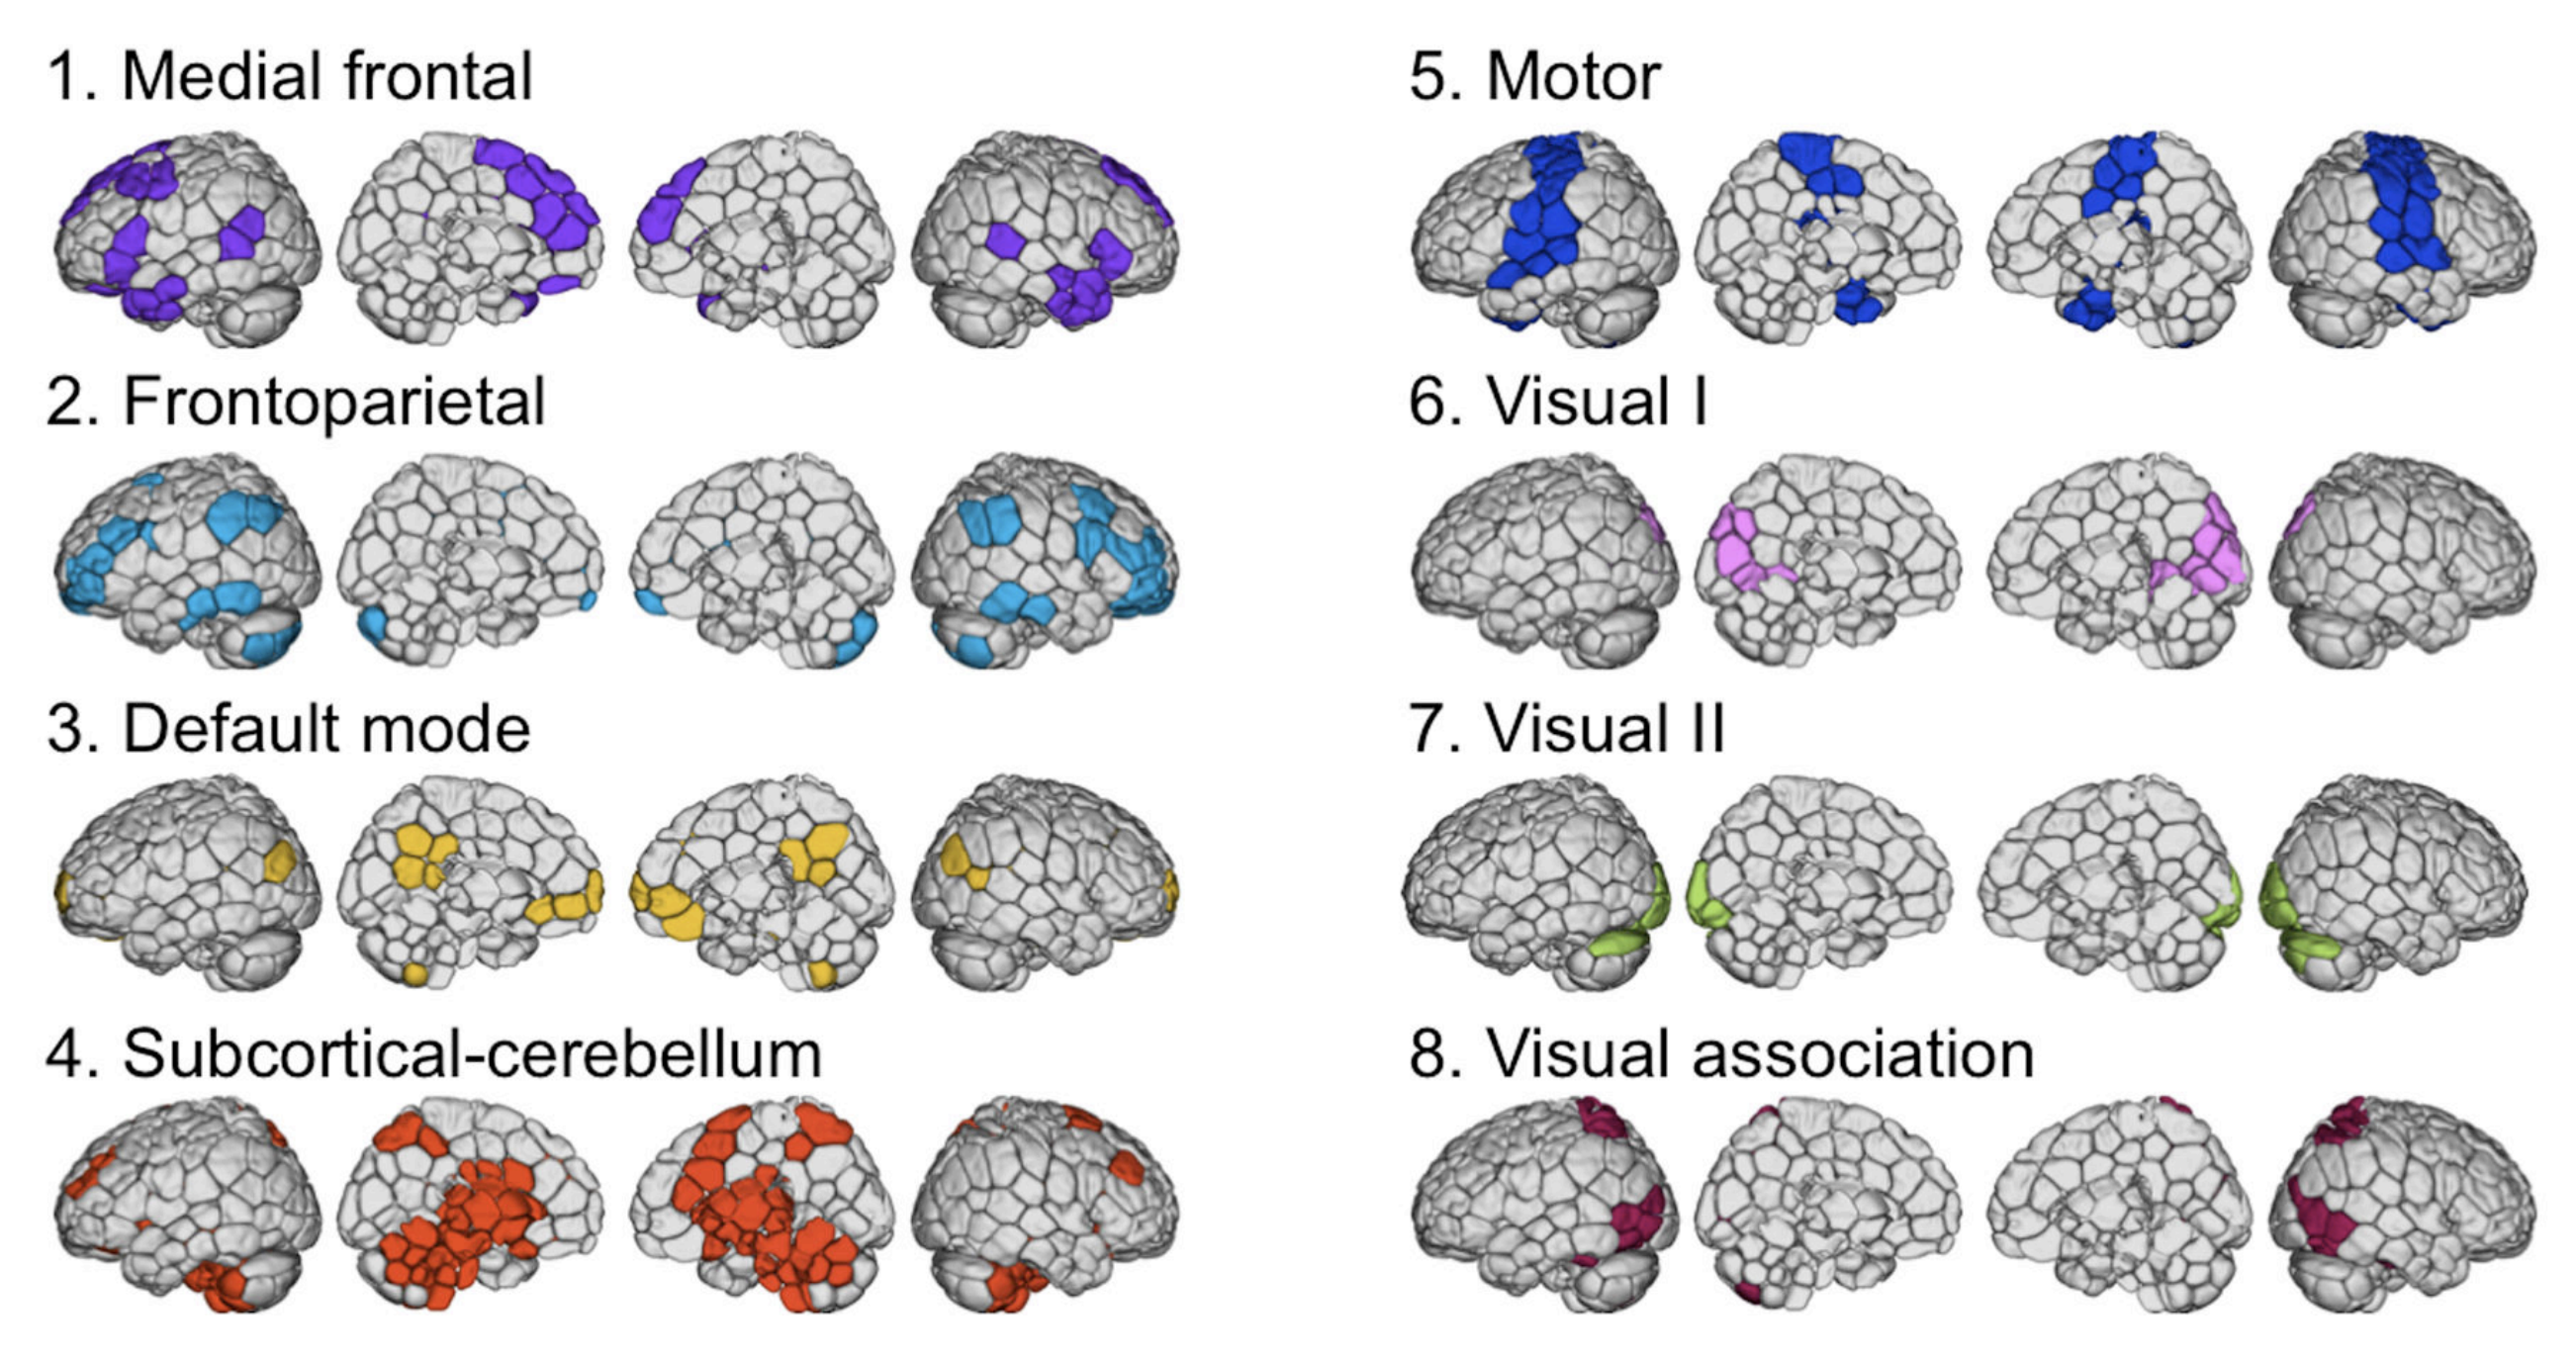

<br>

* Reference
    * Shen, X., Tokoglu, F., Papademetris, X., Constable, R.T.. Groupwise whole-brain parcellation from resting-state fMRI data for network node identification, Neuroimage, 82, 403-15, 2013.
    * Finn, E., Shen, X., Scheinost, D. et al. Functional connectome fingerprinting: identifying individuals using patterns of brain connectivity. Nat Neurosci 18, 1664–1671, 2015.
    * Horien, C., Shen, X., Scheinost, D., Constable, R.T.. The individual functional connectome is unique and stable over months to years. NeuroImage 189, 676–687, 2019.

# HCM dataset

## Data Load

In [77]:
proj_dir=os.getcwd()
hcp_dir=(proj_dir +  '/hcp_data')

In [78]:
os.listdir(hcp_dir)

['.DS_Store',
 'shen_edge_info.csv',
 'fc_wm_df.csv',
 'fc_rest_df.csv',
 'fc_lang_df.csv',
 'fc_gamble_df.csv',
 'fc_social_df.csv',
 'behav_df.csv']

### behavior data

* PMAT24_A_CR: Fluid intelligence (# items correct on Raven's progressive matrices task)
* ListSort_Unadj: Working memory (list sorting task)
* PicVocab_Unadj: Picture vocabulary (verbal IQ)
* ReadEng_Unadj: Reading (verbal IQ)
* ProcSpeed_Unadj: Processing speed
* PicSeq_Unadj: Episodic memory (picture sequence)
* DDisc_AUC_40K: Measure of delay discounting

In [79]:
# behav data
behav_dat = pd.read_csv('%s/behav_df.csv' % (hcp_dir))
behav_dat = behav_dat[['Subject', 'PMAT24_A_CR', 'ListSort_Unadj', 'PicVocab_Unadj', 
           'ReadEng_Unadj', 'ProcSpeed_Unadj', 'PicSeq_Unadj',
          'DDisc_AUC_40K']]
behav_dat.columns = ['sn', 'fi', 'wm', 'viq1', 'viq2', 'ps', 'lm', 'dd']

In [80]:
behav_dat.head(3)

sn  fi      wm       viq1      viq2      ps      lm        dd
0  100206  20  112.89  119.89140  113.5460  138.72  125.07  0.050000
1  100610  23  117.39  140.81510  141.3166  111.11  109.04  0.868750
2  101006  11   93.90   95.42348  113.5374   90.59   84.68  0.783073

### sFC data

* rest - fc_rest_df.csv
* wm - fc_wm_df.csv
* language - fc_lang_df.csv
* gamlbing - fc_gamble_df.csv
* social - fc_social_df.csv

In [81]:
# fMRI data
fMRI_dat = pd.read_csv('%s/fc_wm_df.csv' % (hcp_dir))
fMRI_dat.rename(columns={'Unnamed: 0':'sn'}, inplace =True)

In [82]:
fMRI_dat.head(3)

sn        0        1        2        3        4        5        6  \
0  100206  0.09445  0.20970  0.09945 -0.08035  0.02295  0.06575  0.12480   
1  100610  0.00705  0.04235  0.03755 -0.04520 -0.01150  0.17820  0.18140   
2  101006 -0.05285 -0.00300  0.05110  0.05520  0.13180  0.14115  0.16645   

         7        8  ...    35768    35769    35770    35771    35772  \
0 -0.01735  0.08415  ... -0.00625  0.02345  0.05515  0.05585 -0.11020   
1  0.15245  0.08160  ...  0.04685  0.05340 -0.02835  0.05240 -0.07905   
2  0.04335  0.10420  ...  0.08555 -0.03635 -0.14520 -0.07760 -0.00390   

     35773    35774    35775    35776    35777  
0  0.05545  0.02955 -0.00635  0.00265  0.03775  
1  0.01390  0.17020  0.03995  0.00625  0.14390  
2 -0.11595 -0.07515  0.02550 -0.04360  0.08760  

[3 rows x 35779 columns]

## EDA & Preprocessing

### data type

In [10]:
behav_dat.dtypes

sn        int64
fi        int64
wm      float64
viq1    float64
viq2    float64
ps      float64
lm      float64
dd      float64
dtype: object

In [11]:
fMRI_dat.dtypes

sn         int64
0        float64
1        float64
2        float64
3        float64
          ...   
35773    float64
35774    float64
35775    float64
35776    float64
35777    float64
Length: 35779, dtype: object

### Check Nan

In [12]:
behav_dat.isnull().sum().sum(), fMRI_dat.isnull().sum().sum()

(0, 0)

In [83]:
df_target = fMRI_dat.copy()
df_label = behav_dat.copy()

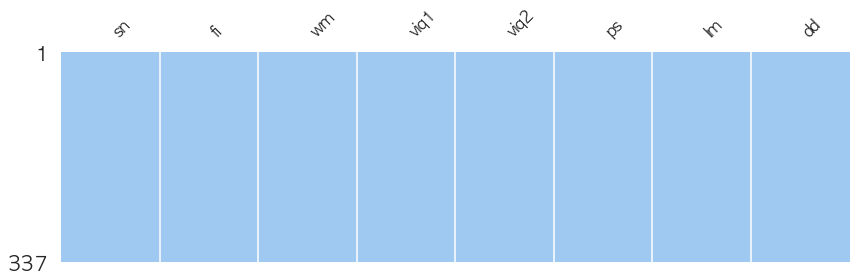

In [14]:
fig, ax = plt.subplots(1,1,figsize=(12, 4))
msno.matrix(df=df_label, color=(0.63, 0.79, 0.95), ax = ax)
# msno.matrix(df=df_target, color=(0.54, 0.81, 0.94))
plt.tight_layout()
plt.show()

### Check Distribution

* Behavior Data

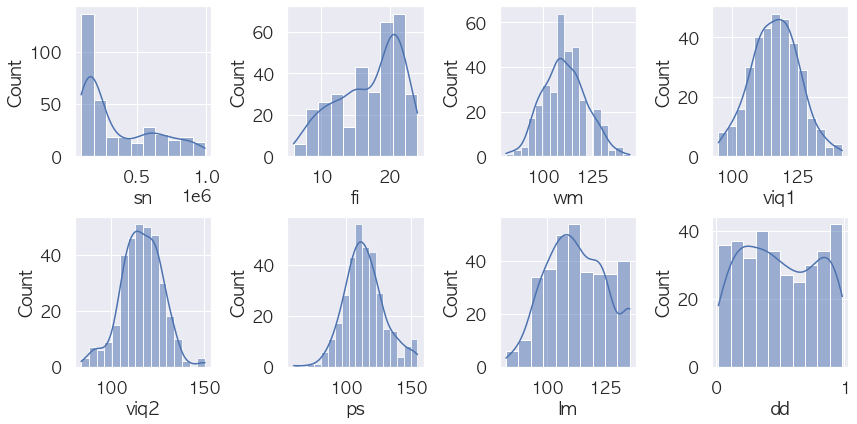

In [15]:
ax_list = []
t_col = ['sn', 'fi', 'wm', 'viq1', 'viq2', 'ps', 'lm', 'dd']
for i in range(2):
    for j in range(4):
        ax_list.append([int(i),int(j)])

fig, axes = plt.subplots(nrows= 2, ncols= 4, figsize=[12, 6])
for idx, name in enumerate(ax_list):
    sns.histplot(data=df_label[('%s' % (t_col[idx]))], kde=True, ax=axes[name[0], name[1]])
plt.tight_layout()
plt.show()

* fc data

In [16]:
df_target.shape

(337, 35779)

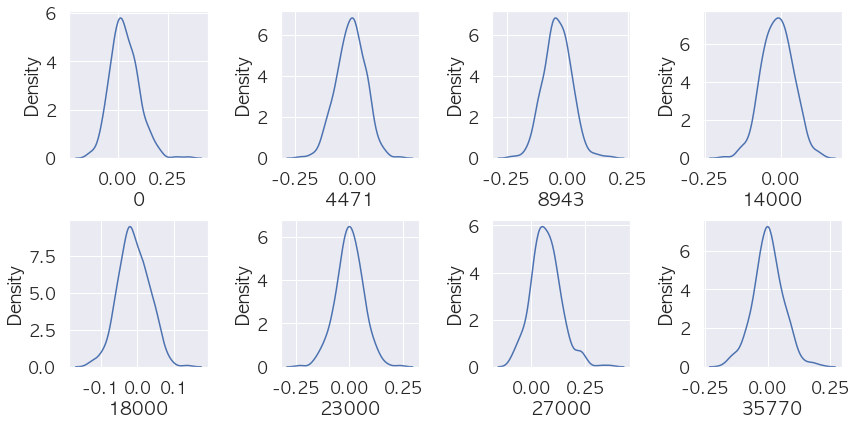

In [17]:
ax_list = []
t_col = ['0', '4471', '8943', '14000', '18000', '23000', '27000', '35770']
for i in range(2):
    for j in range(4):
        ax_list.append([int(i),int(j)])

fig, axes = plt.subplots(nrows= 2, ncols= 4, figsize=[12, 6])
for idx, name in enumerate(ax_list):
    sns.kdeplot(data=df_target[('%s' % (t_col[idx]))], ax=axes[name[0], name[1]])
plt.tight_layout()
plt.show()

### Check Outliers

In [18]:
def outlier_check(df, method=1):

    if method == 1:  # Boxplot Method
        Q1 = df.quantile(0.25)
        Q3 = df.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1-(IQR*1.5)
        upper = Q1+(IQR*1.5)

    elif method == 2:  # Normal Distribution Method
        Mean = df.mean()
        std = df.std()
        lower = Mean-std*3
        upper = Mean+std*3

    out_mask = ((df < lower) | (df > upper))
    out_info = pd.concat([pd.DataFrame(lower, columns=['lower']),
                          pd.DataFrame(upper, columns=['upper']),
                          pd.DataFrame(df.min(), columns=['min']),
                          pd.DataFrame(df.max(), columns=['max']),
                          pd.DataFrame(((df < lower) | (df > upper)).sum(), columns=['counts'])], axis=1)
    return out_info, out_mask

* Behavior data

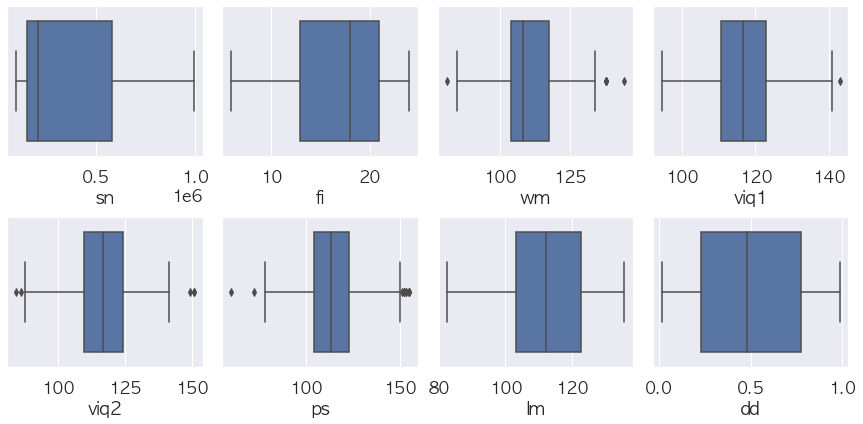

In [19]:
ax_list = []
t_col = ['sn', 'fi', 'wm', 'viq1', 'viq2', 'ps', 'lm', 'dd']
for i in range(2):
    for j in range(4):
        ax_list.append([int(i),int(j)])
fig, ax = plt.subplots(nrows= 2, ncols= 4, figsize=[12, 6])
for idx, name in enumerate(ax_list):
    sns.boxplot(x=df_label[('%s' % (t_col[idx]))], ax = ax[name[0], name[1]])
plt.tight_layout()
plt.show()    

In [20]:
behav_info, behav_mask = outlier_check(df_label, 2) # 3sd method

In [21]:
behav_info

lower         upper            min            max  counts
sn   -431501.421111  1.158559e+06  100206.000000  994273.000000       0
fi         2.906306  3.111150e+01       6.000000      24.000000       0
wm        77.784480  1.438458e+02      80.790000     144.500000       1
viq1      88.714911  1.446018e+02      94.571660     142.830100       0
viq2      83.861033  1.492981e+02      84.200000     150.710000       2
ps        67.888879  1.609584e+02      60.090000     154.690000       1
lm        73.837417  1.517133e+02      82.370000     135.550000       0
dd        -0.382529  1.379271e+00       0.015625       0.984375       0

* fc data

In [22]:
fc_info, fc_mask = outlier_check(df_target, 2) # 3sd method

In [23]:
fc_info.counts.sum()

73730

In [24]:
fc_info.counts.sum()/(df_target.shape[0]*df_target.shape[1])

0.006114854601562858

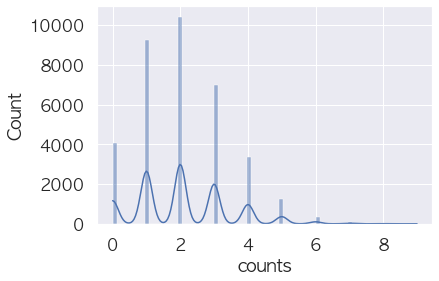

In [25]:
sns.histplot(fc_info.counts, kde = True)
plt.show()

### Visualization

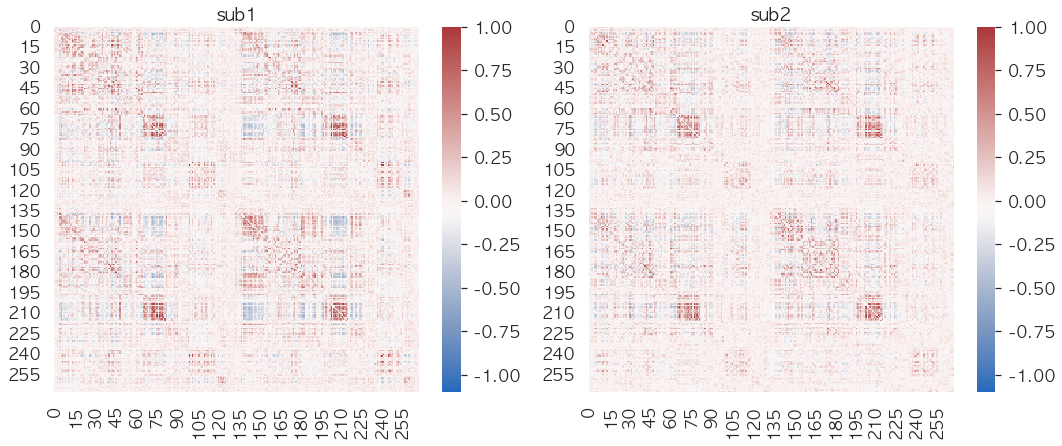

In [26]:
fig, axes = plt.subplots(1, 2, figsize=[15, 6])

g1 = sns.heatmap(sp.spatial.distance.squareform(df_target.iloc[0,1:]),
                 vmax=-1, vmin=+1, 
                 square=True, cmap="vlag",
                 linecolor='white', ax = axes[0])
g1.set_title('sub1')
g2 = sns.heatmap(sp.spatial.distance.squareform(df_target.iloc[1,1:]),
                 vmax=-1, vmin=+1, 
                 square=True, cmap="vlag",
                 linecolor='white', ax = axes[1])
g2.set_title('sub2')
plt.tight_layout()
plt.show()

## Feature Engineering

### Auto Feature Scaling & Selection

In [27]:
subj_idx = list(behav_dat.sn.values)

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import VarianceThreshold, mutual_info_regression, f_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.cross_decomposition import PLSRegression

# fs_method = ['none', 'VarThr', 'InfGain', 'f-Reg']
fs_method = ['none', 'VarThr', 'f-Reg']
# 0 - none, 1 - variance Threshold, 2 - Information Gain, 3 - F-regression


fs_results = [];
x_fs = [];
x_tSn = [];
x_tSn_act = [];
x_tSn_r_pred = [];
x_nFeature = [];

for fs_idx, fs_name in enumerate(fs_method):
    
    print("%d. method %s processing ----------------------------\n\n" % (fs_idx+1, fs_name))
    for idx, this_sub in enumerate(subj_idx):

        # subject index
        train_subj = deepcopy(subj_idx)
        train_subj.remove(this_sub)
        test_subj = this_sub                                   

        # prepare data             
        X_train_r = df_target.loc[df_target['sn'] != test_subj, '0':]
        y_train = df_label.loc[df_label['sn'] != test_subj, 'fi']
        X_test_r = df_target.loc[df_target['sn'] == test_subj, '0':]
        y_test = df_label.loc[df_label['sn'] == test_subj, 'fi']
        
        # feature scaling 
        scaler = StandardScaler()
        targ_col = X_train_r.columns.values
        X_train_r = scaler.fit_transform(X_train_r)
        X_train_r = pd.DataFrame(X_train_r)
        X_train_r.columns = targ_col
        X_test_r = scaler.transform(X_test_r)
        X_test_r = pd.DataFrame(X_test_r)
        X_test_r.columns = targ_col
        
        # feature selection
        if fs_name == 'none':
            
            X_train_r_fs = np.array(X_train_r)
            X_test_r_fs = np.array(X_test_r)
            y_train_fs = np.array(y_train)
            y_test_fs = np.array(y_test)
            
        elif fs_name == 'VarThr': # Variance Threshold
            
            Threshold = 0.2
            selector_var=VarianceThreshold(threshold=Threshold)
            selector_var.fit(X_train_r)            
            is_support_var = selector_var.variances_ > Threshold
            
            X_train_r_fs = np.array(X_train_r[X_train_r.columns[is_support_var].values])
            X_test_r_fs = np.array(X_test_r[X_test_r.columns[is_support_var].values])
            y_train_fs = np.array(y_train)
            y_test_fs = np.array(y_test)
            
        elif fs_name == 'InfGain': # Information Gain
            
            Threshold = 0.02
            selector_ifg=SelectKBest(mutual_info_regression, k='all')
            selector_ifg.fit(X_train_r, y_train)
            is_support_ifg = selector_ifg.scores_ > Threshold
            
            X_train_r_fs = np.array(X_train_r[X_train_r.columns[is_support_ifg].values])
            X_test_r_fs = np.array(X_test_r[X_test_r.columns[is_support_ifg].values])
            y_train_fs = np.array(y_train)
            y_test_fs = np.array(y_test)
            
        elif fs_name == 'f-Reg':
            
            Threshold = 0.05
            selector_freg=SelectKBest(f_regression, k='all')
            selector_freg.fit(X_train_r, y_train)
            is_support_freg = selector_freg.pvalues_ < Threshold
            
            X_train_r_fs = np.array(X_train_r[X_train_r.columns[is_support_freg].values])
            X_test_r_fs = np.array(X_test_r[X_test_r.columns[is_support_freg].values])
            y_train_fs = np.array(y_train)
            y_test_fs = np.array(y_test)
            
        #model_r = Ridge()
        model_r = Ridge()
        model_r.fit(X_train_r_fs, y_train_fs)
        y_pred_r = model_r.predict(X_test_r_fs) 
                
        x_fs.append(fs_name)
        x_tSn.append(this_sub)
        x_tSn_act.append(y_test_fs[0]);
        x_tSn_r_pred.append(y_pred_r[0]);        
        x_nFeature.append(X_train_r_fs.shape[1])
        
    print("%d. method %s done ----------------------------\n\n" % (fs_idx+1, fs_name))

fs_results = pd.DataFrame({'fs_method': x_fs,
                           'tSN': x_tSn,
                           'behav_act': x_tSn_act,                            
                           'behav_pred': x_tSn_r_pred,
                           'nFeature': x_nFeature})

1. method none processing ----------------------------


1. method none done ----------------------------


2. method VarThr processing ----------------------------


2. method VarThr done ----------------------------


3. method f-Reg processing ----------------------------


3. method f-Reg done ----------------------------




In [29]:
fs_results

fs_method     tSN  behav_act  behav_pred  nFeature
0         none  100206         20   18.725468     35778
1         none  100610         23   19.902389     35778
2         none  101006         11   15.176511     35778
3         none  101309         15   15.269803     35778
4         none  101915         21   18.415946     35778
...        ...     ...        ...         ...       ...
1006     f-Reg  966975         14   14.221206      6245
1007     f-Reg  984472         22   20.210941      6201
1008     f-Reg  987983         22   20.596465      6172
1009     f-Reg  993675         21   20.229134      6160
1010     f-Reg  994273         20   16.056627      6215

[1011 rows x 5 columns]

In [30]:
fs_method = ['none', 'VarThr', 'f-Reg']

x_fs = [];
x_corr = [];
x_corr_p = [];
x_rmse = [];
x_mape = [];
x_nf = [];

for idx, name in enumerate(fs_method):
    
    tmp_df= fs_results.loc[fs_results['fs_method'] == name, ['behav_act', 'behav_pred', 'nFeature']]
    tmp_corr = pg.corr(tmp_df.behav_act, tmp_df.behav_pred)    
    rmse = mean_squared_error(tmp_df['behav_act'], tmp_df['behav_pred'])**0.5
    mape = mean_absolute_percentage_error(tmp_df['behav_act'], tmp_df['behav_pred'])
    
    x_fs.append(name)
    x_corr.append(tmp_corr['r'][0])
    x_corr_p.append(tmp_corr['p-val'][0])
    x_rmse.append(rmse)
    x_mape.append(mape)
    x_nf.append(np.mean(tmp_df.nFeature))
    
fs_fnl = pd.DataFrame({'fs_method': x_fs,
                       'r' : x_corr,
                       'p_r' : x_corr_p,
                       'rmse' : x_rmse,
                       'mape' : x_mape,
                       'nF' : x_nf})

In [31]:
fs_fnl

fs_method         r           p_r      rmse      mape            nF
0      none  0.497236  1.898063e-22  4.072995  0.242767  35778.000000
1    VarThr  0.497236  1.898063e-22  4.072995  0.242767  35778.000000
2     f-Reg  0.497236  1.898063e-22  4.165178  0.249607   6189.038576

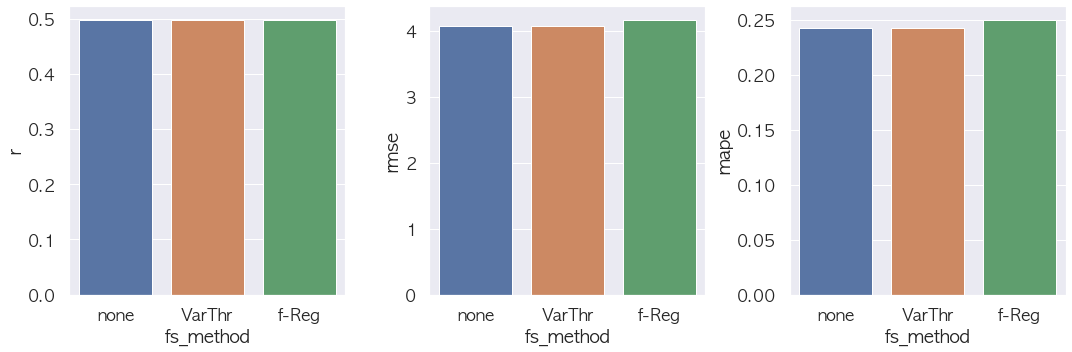

In [32]:
fig, axes = plt.subplots(1,3, figsize = [15,5])
sns.barplot(data=fs_fnl, x='fs_method', y ='r', ax = axes[0])
sns.barplot(data=fs_fnl, x='fs_method', y ='rmse', ax = axes[1])
sns.barplot(data=fs_fnl, x='fs_method', y ='mape', ax = axes[2])
plt.tight_layout()
plt.show()

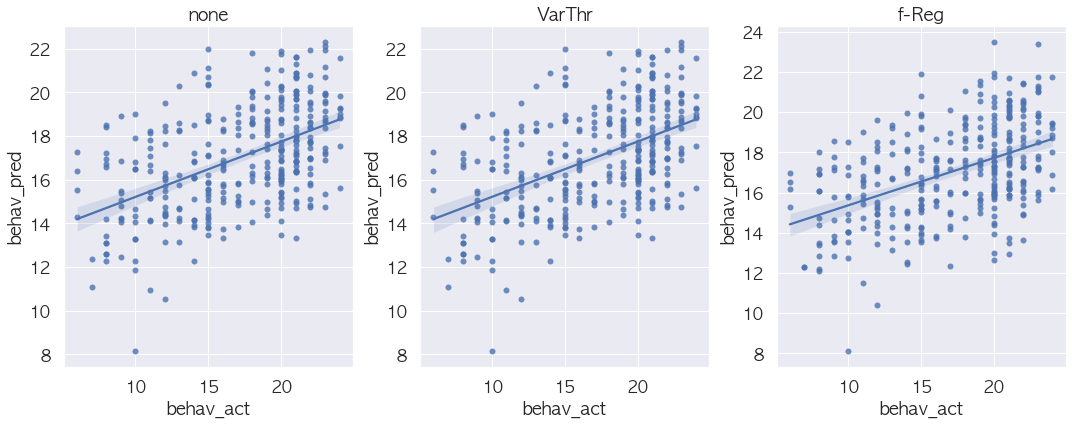

In [33]:
fig, axes = plt.subplots(1,3, figsize = [15,6])
for idx, name in enumerate(fs_method):
    tmp_df= fs_results.loc[fs_results['fs_method'] == name, ['behav_act', 'behav_pred']]
    sns.regplot(x='behav_act', y='behav_pred', data=tmp_df, ax = axes[idx]);
    axes[idx].set_title(('%s' % name))
plt.tight_layout()
plt.show()

* Feature Selection을 하지 않은 버전이 가장 우수한 수행을 보였음.

## CPM

* 교차 검증 기법을 사용하여 connectivity 데이터로 brain-behavior 간의 Predictive Model을 개발한다.
* 상대적으로 부족한 case수(n = 337)와 복잡한 fc데이터의 차원(38000~), 서로 간의 공변성을 가진 fc 데이터의 특성을 고려하여 수가 많고 서로 간의 밀접한 상관관계를 가진 데이터로 모델링을 수행하는 PLSR을 사용하였다.
* 비교를 위해 Ridge, Lasso, Linear SVR을 함께 확인한다.

In [34]:
# import module
from sklearn.cross_decomposition import PLSRegression

from sklearn.linear_model import LinearRegression, BayesianRidge, Ridge, Lasso, BayesianRidge
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import KFold, LeaveOneOut, GridSearchCV
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error


### PLSR Optimization

* PLSR에서 적절한 성분 수를 찾기 위한 최적화 작업을 수행한다.

In [35]:
def optimise_pls_cv(X, y, n_comp):
    # Define PLS object
    pls = PLSRegression(n_components=n_comp)

    # Cross-validation
    y_cv = cross_val_predict(pls, X, y, cv=12)

    # Calculate scores
    r2 = r2_score(y, y_cv)
    mse = mean_squared_error(y, y_cv)
    rpd = y.std()/np.sqrt(mse)
    
    return (y_cv, r2, mse, rpd)

def pick_nc(vals1, vals2, vals3, ylabel1, ylabel2, ylabel3, objective1, objective2, objective3):
    if objective1 == 'min':
        idx = np.argmin(vals1)
    else:
        idx = np.argmax(vals1)
    
    if objective2 == 'min':
        idx = np.argmin(vals2)
    else:
        idx = np.argmax(vals2)

    if objective3=='min':
        idx = np.argmin(vals3)
    else:
        idx = np.argmax(vals3)
        
    nc = xticks[idx]
    return nc
        

# Plot the mses
def plot_metrics(vals1, vals2, vals3, ylabel1, ylabel2, ylabel3, objective1, objective2, objective3):
    with plt.style.context('ggplot'):
        plt.subplot(1,3,1)
        plt.plot(xticks, np.array(vals1), '-v', color='blue', mfc='blue')
        if objective1=='min':
            idx = np.argmin(vals1)
        else:
            idx = np.argmax(vals1)
        plt.plot(xticks[idx], np.array(vals1)[idx], 'P', ms=10, mfc='red')
        plt.xlabel('Number of PLS components')
        plt.xticks = xticks
        plt.ylabel(ylabel1)
        plt.title('PLS - nComp %d' % xticks[idx])
                                           
        plt.subplot(1,3,2)
        plt.plot(xticks, np.array(vals2), '-v', color='blue', mfc='blue')
        if objective2=='min':
            idx = np.argmin(vals2)
        else:
            idx = np.argmax(vals2)
        plt.plot(xticks[idx], np.array(vals2)[idx], 'P', ms=10, mfc='red')
        plt.xlabel('Number of PLS components')
        plt.xticks = xticks
        plt.ylabel(ylabel2)
        plt.title('PLS - nComp %d' % xticks[idx])
                                           
        plt.subplot(1,3,3)
        plt.plot(xticks, np.array(vals3), '-v', color='blue', mfc='blue')
        if objective3=='min':
            idx = np.argmin(vals3)
        else:
            idx = np.argmax(vals3)
        plt.plot(xticks[idx], np.array(vals3)[idx], 'P', ms=10, mfc='red')
        plt.xlabel('Number of PLS components')
        plt.xticks = xticks
        plt.ylabel(ylabel3)
        plt.title('PLS - Comp %d' % xticks[idx])
        
        nc = xticks[idx]
        
        return nc
    plt.show()

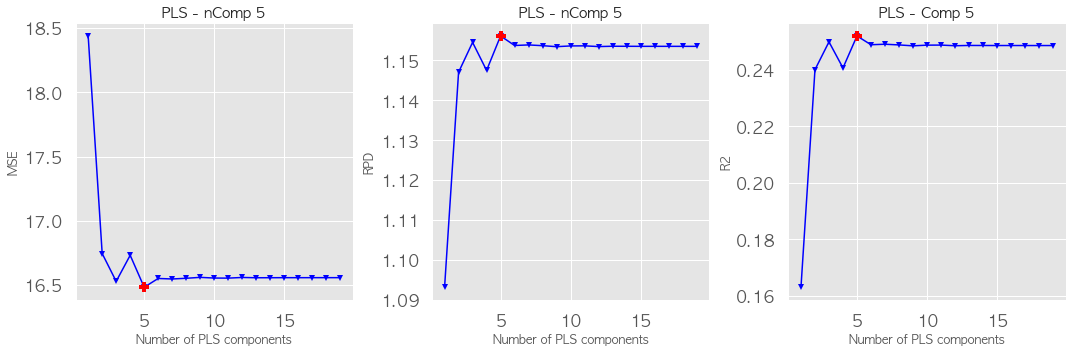


Rest-sFC / ncomp: 5


In [36]:
x_targ = np.array(df_target.loc[:, '0':])
y_targ = np.array(df_label.loc[:,'fi'])
                  
# test with 20 components
r2s_r = []; mses_r = []; rpds_r = [];
xticks = np.arange(1, 20)
for n_comp in xticks:
    y_cv, r2, mse, rpd = optimise_pls_cv(x_targ, y_targ, n_comp)
    r2s_r.append(r2)
    mses_r.append(mse)
    rpds_r.append(rpd)
    
plt.figure(figsize=(15,5))
nc=plot_metrics(mses_r, rpds_r, r2s_r, 'MSE', 'RPD', 'R2', 'min', 'max', 'max')
plt.tight_layout()
plt.show()
print("\nRest-sFC", "/", "ncomp:", nc)
nc_r = nc


### Model Selection

* 간단한 모델링으로 모델 별 성능을 비교한다.

In [37]:
Pls = PLSRegression(n_components=nc_r)
Ridge = Ridge()
Lasso = Lasso()
SVR = LinearSVR()
# Linear = LinearRegression()
# bRdige = BayesianRidge()
# Tree = DecisionTreeRegressor()

Model_list = [Pls, Ridge, Lasso, SVR]

In [38]:
def simple_fit(model, X_train, y_train):
    
    cv = KFold(n_splits = 10, random_state = 0, shuffle=True)
    y_pred = cross_val_predict(model, X_train, y_train, cv=cv)
    train_mse = mean_squared_error(y_train, y_pred)
    train_rmse = mean_squared_error(y_train, y_pred)**0.5
    train_mape = mean_absolute_percentage_error(y_train, y_pred)
    train_r2 = r2_score(y_train, y_pred)

    return y_pred.flatten(), train_mse, train_rmse, train_mape, train_r2

In [39]:
ms_df = pd.DataFrame(columns=[
                     'Model', 'MSE', 'RMSE', 'MAPE', 'R2', 'r', 'r_p'])

x_targ = np.array(df_target.loc[:, '0':])
y_targ = np.array(df_label.loc[:,'fi'])

i = 0
for model in Model_list:
    i += 1
    print(model)
    y_pred, train_mse, train_rmse, train_mape, train_r2  = simple_fit(model, x_targ, y_targ)
    
    tmp_corr = pg.corr(y_targ, y_pred)
    
    

    ms_tmp = {'Model': str(model),
              'MSE': train_mse,
              'RMSE': train_rmse,
              'MAPE': train_mape ,
              'R2': train_r2 , 
              'r': tmp_corr['r'][0],
              'r_p': tmp_corr['p-val'][0]}
    ms_df = ms_df.append(ms_tmp, ignore_index=True)
    

PLSRegression(n_components=5)
Ridge()
Lasso()
LinearSVR()


In [40]:
ms_df

Model        MSE      RMSE      MAPE        R2  \
0  PLSRegression(n_components=5)  16.763407  4.094314  0.243158  0.239153   
1                        Ridge()  17.535706  4.187566  0.247941  0.204100   
2                        Lasso()  22.168176  4.708309  0.300326 -0.006155   
3                    LinearSVR()  18.228896  4.269531  0.250454  0.172638   

          r           r_p  
0  0.489318  1.086707e-21  
1  0.462284  3.019919e-19  
2 -0.161368  2.970222e-03  
3  0.454301  1.449408e-18

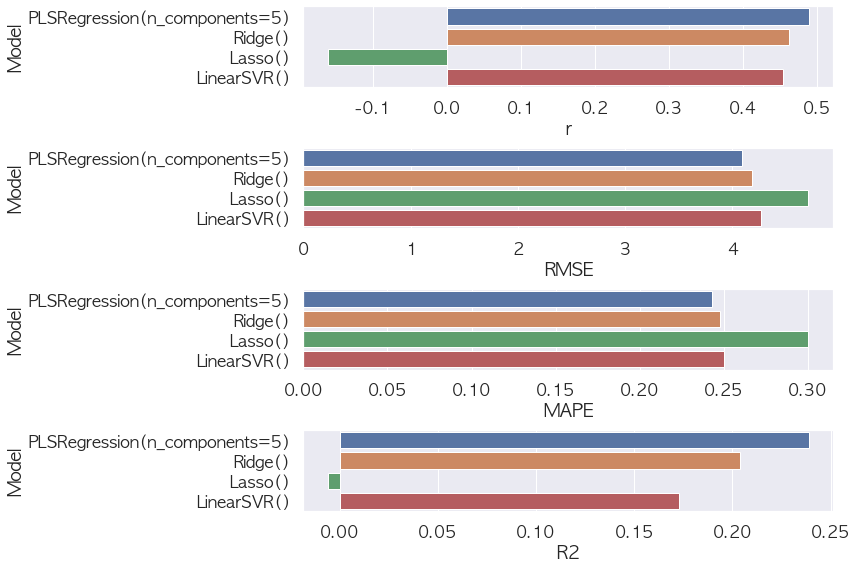

In [41]:
fig, axes = plt.subplots(4,1, figsize = [12,8])
sns.barplot(data=ms_df, y='Model', x ='r', ax = axes[0])
sns.barplot(data=ms_df, y='Model', x ='RMSE', ax = axes[1])
sns.barplot(data=ms_df, y='Model', x ='MAPE', ax = axes[2])
sns.barplot(data=ms_df, y='Model', x ='R2', ax = axes[3])
plt.tight_layout()
plt.show()

* PLSR의 성능이 가장 우수하였다. 

### Modeling

* WM sFC 데이터를 활용하여 7개 behavior 측정치와의 모델링을 수행하였다.
* Feature Selection 여부에 따른 효과를 재확인하기 위해 none, f-regression을 함께 수행한다.

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import VarianceThreshold, mutual_info_regression, f_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.cross_decomposition import PLSRegression

In [43]:
subj_idx = list(behav_dat.sn.values)

In [44]:
#b_type = ['fi', 'wm', 'viq1', 'viq2', 'ps', 'lm', ' dd']
b_type = ['fi', 'wm', 'viq1', 'viq2', 'ps', 'lm', 'dd']
fs_method = ['none', 'f-Reg']


fs_results = [];
x_model = [];
x_model_comp = [];
x_btype = [];
x_fs = [];
x_tSn = [];
x_tSn_act = [];
x_tSn_r_pred = [];
x_nFeature = [];


for b_idx , b_name in enumerate(b_type):

    for fs_idx, fs_name in enumerate(fs_method):

        print("%d. %s, %s processing ----------------------------\n\n" % (fs_idx+1, b_name, fs_name))
        for idx, this_sub in enumerate(subj_idx):

            # subject index
            train_subj = deepcopy(subj_idx)
            train_subj.remove(this_sub)
            test_subj = this_sub                                   

            # prepare data             
            X_train_r = df_target.loc[df_target['sn'] != test_subj, '0':]
            y_train = df_label.loc[df_label['sn'] != test_subj, b_name]
            X_test_r = df_target.loc[df_target['sn'] == test_subj, '0':]
            y_test = df_label.loc[df_label['sn'] == test_subj, b_name]

            # feature scaling 
            scaler = StandardScaler()
            targ_col = X_train_r.columns.values
            X_train_r = scaler.fit_transform(X_train_r)
            X_train_r = pd.DataFrame(X_train_r)
            X_train_r.columns = targ_col
            X_test_r = scaler.transform(X_test_r)
            X_test_r = pd.DataFrame(X_test_r)
            X_test_r.columns = targ_col

            # feature selection
            if fs_name == 'none':

                X_train_r_fs = np.array(X_train_r)
                X_test_r_fs = np.array(X_test_r)
                y_train_fs = np.array(y_train)
                y_test_fs = np.array(y_test)

            elif fs_name == 'f-Reg':

                Threshold = 0.05
                selector_freg=SelectKBest(f_regression, k='all')
                selector_freg.fit(X_train_r, y_train)
                is_support_freg = selector_freg.pvalues_ < Threshold

                X_train_r_fs = np.array(X_train_r[X_train_r.columns[is_support_freg].values])
                X_test_r_fs = np.array(X_test_r[X_test_r.columns[is_support_freg].values])
                y_train_fs = np.array(y_train)
                y_test_fs = np.array(y_test)
                
            # PLSR optimization
            r2s_r = []; mses_r = []; rpds_r = [];
            xticks = np.arange(1, 10)
            for n_comp in xticks:
                y_cv, r2, mse, rpd = optimise_pls_cv(x_targ, y_targ, n_comp)
                r2s_r.append(r2)
                mses_r.append(mse)
                rpds_r.append(rpd)
            nc = pick_nc(mses_r, rpds_r, r2s_r, 'MSE', 'RPD', 'R2', 'min', 'max', 'max')
            nc = 5
            
            # Model Fitting & Test
            model_r = PLSRegression(n_components=nc)
            model_r.fit(X_train_r_fs, y_train_fs)
            y_pred_r = model_r.predict(X_test_r_fs) 
            
            
            # saving results
            x_model.append('PLSR')
            x_model_comp.append(nc)
            x_btype.append(b_name)
            x_fs.append(fs_name)
            x_tSn.append(this_sub)
            x_tSn_act.append(y_test_fs[0]);
            x_tSn_r_pred.append(y_pred_r[0]);        
            x_nFeature.append(X_train_r_fs.shape[1])

        print("%d. %s, %s done ----------------------------\n\n" % (fs_idx+1, b_name, fs_name))

fs_results = pd.DataFrame({'model': x_model,
                           'mComp': x_model_comp,
                           'ability': x_btype,
                           'fs': x_fs,
                           'nFeature': x_nFeature,
                           'tSN': x_tSn,
                           'behav_act': x_tSn_act,                            
                           'behav_pred': x_tSn_r_pred})

1. fi, none processing ----------------------------


1. fi, none done ----------------------------


2. fi, f-Reg processing ----------------------------


2. fi, f-Reg done ----------------------------


1. wm, none processing ----------------------------


1. wm, none done ----------------------------


2. wm, f-Reg processing ----------------------------


2. wm, f-Reg done ----------------------------


1. viq1, none processing ----------------------------


1. viq1, none done ----------------------------


2. viq1, f-Reg processing ----------------------------


2. viq1, f-Reg done ----------------------------


1. viq2, none processing ----------------------------


1. viq2, none done ----------------------------


2. viq2, f-Reg processing ----------------------------


2. viq2, f-Reg done ----------------------------


1. ps, none processing ----------------------------


1. ps, none done ----------------------------


2. ps, f-Reg processing ----------------------------


2. 

In [45]:
fs_results = pd.DataFrame({'model': x_model,
                           'mComp': x_model_comp,
                           'ability': x_btype,
                           'fs': x_fs,
                           'nFeature': x_nFeature,
                           'tSN': x_tSn,
                           'behav_act': x_tSn_act,                            
                           'behav_pred': x_tSn_r_pred})

In [48]:
fs_results.behav_pred = np.concatenate(fs_results.behav_pred)
fs_results.to_csv('hcp_plsr_allBehav.csv')
fs_results

model  mComp ability     fs  nFeature     tSN  behav_act  behav_pred
0     PLSR      5      fi   none     35778  100206  20.000000   18.815125
1     PLSR      5      fi   none     35778  100610  23.000000   19.961088
2     PLSR      5      fi   none     35778  101006  11.000000   15.335247
3     PLSR      5      fi   none     35778  101309  15.000000   15.364958
4     PLSR      5      fi   none     35778  101915  21.000000   18.361611
...    ...    ...     ...    ...       ...     ...        ...         ...
4713  PLSR      5      dd  f-Reg      4191  966975   0.358203    0.289030
4714  PLSR      5      dd  f-Reg      4212  984472   0.760156    0.471012
4715  PLSR      5      dd  f-Reg      4194  987983   0.245703    0.484450
4716  PLSR      5      dd  f-Reg      4178  993675   0.938281    0.438770
4717  PLSR      5      dd  f-Reg      4194  994273   0.529427    0.670261

[4718 rows x 8 columns]

### Results

In [49]:
b_type = ['fi', 'wm', 'viq1', 'viq2', 'ps', 'lm', 'dd']
fs_method = ['none', 'f-Reg']

x_model = [];
x_nComp = [];
x_fs = [];
x_b = [];
x_corr = [];
x_corr_p = [];
x_rmse = [];
x_mape = [];
x_r2 = [];
x_nf = [];

for b_idx, b_name in enumerate(b_type):
    tmp_df_raw = fs_results.loc[fs_results['ability'] == b_name,:]
    for fs_idx, fs_name in enumerate(fs_method):

        tmp_df = tmp_df_raw.loc[tmp_df_raw['fs'] == fs_name, 
                                ['model', 'mComp', 'fs', 'ability', 'behav_act', 'behav_pred', 'nFeature']].copy()

        tmp_corr = pg.corr(tmp_df['behav_act'], tmp_df['behav_pred']).copy()
        rmse = mean_squared_error(tmp_df['behav_act'], tmp_df['behav_pred'])**0.5
        mape = mean_absolute_percentage_error(tmp_df['behav_act'], tmp_df['behav_pred'])
        r2 = r2_score(tmp_df['behav_act'], tmp_df['behav_pred'])    

        x_model.append(tmp_df.iloc[0,0])
        x_nComp.append(np.mean(tmp_df.iloc[:,1]))
        x_b.append(b_name)
        x_fs.append(fs_name)
        x_corr.append(tmp_corr['r'][0])
        x_corr_p.append(tmp_corr['p-val'][0])
        x_rmse.append(rmse)
        x_mape.append(mape)
        x_r2.append(r2)
        x_nf.append(np.mean(tmp_df.nFeature))
    
fs_fnl = pd.DataFrame({'model' : x_model,
                       'mComp' : x_nComp,
                       'ability': x_b,
                       'fs_method': x_fs,
                       'r' : x_corr,
                       'p_r' : x_corr_p,
                       'rmse' : x_rmse,
                       'mape' : x_mape,
                       'r2' : x_r2,
                       'nF' : x_nf})



In [50]:
fs_fnl

model  mComp ability fs_method         r           p_r       rmse  \
0   PLSR    5.0      fi      none  0.505279  3.076689e-23   4.051057   
1   PLSR    5.0      fi     f-Reg  0.449262  3.820149e-18   4.198939   
2   PLSR    5.0      wm      none  0.321662  1.499904e-09  10.563599   
3   PLSR    5.0      wm     f-Reg  0.275815  2.680762e-07  10.796063   
4   PLSR    5.0    viq1      none  0.469098  7.660483e-20   8.221041   
5   PLSR    5.0    viq1     f-Reg  0.430214  1.292015e-16   8.424243   
6   PLSR    5.0    viq2      none  0.431262  1.070621e-16   9.843650   
7   PLSR    5.0    viq2     f-Reg  0.382201  3.648855e-13  10.139635   
8   PLSR    5.0      ps      none  0.192993  3.662562e-04  15.571088   
9   PLSR    5.0      ps     f-Reg  0.118187  3.006977e-02  16.224287   
10  PLSR    5.0      lm      none  0.156225  4.041300e-03  13.192669   
11  PLSR    5.0      lm     f-Reg  0.262775  9.970165e-07  12.749880   
12  PLSR    5.0      dd      none  0.201989  1.893615e-04   0.294782   
13  PLSR    5.0      dd     f-Reg  0.135244  1.295708e-02   0.304925   

        mape        r2            nF  
0   0.240350  0.255145  35778.000000  
1   0.250485  0.199771   6189.038576  
2   0.077487  0.076743  35778.000000  
3   0.079738  0.035661   4629.029674  
4   0.055509  0.218683  35778.000000  
5   0.056750  0.179581   4674.623145  
6   0.066463  0.182932  35778.000000  
7   0.068291  0.133058   4646.296736  
8   0.107523 -0.010685  35778.000000  
9   0.111643 -0.097259   3139.664688  
10  0.095821 -0.036222  35778.000000  
11  0.092030  0.032169   2665.094955  
12  1.581147 -0.010835  35778.000000  
13  1.628199 -0.081599   4186.928783

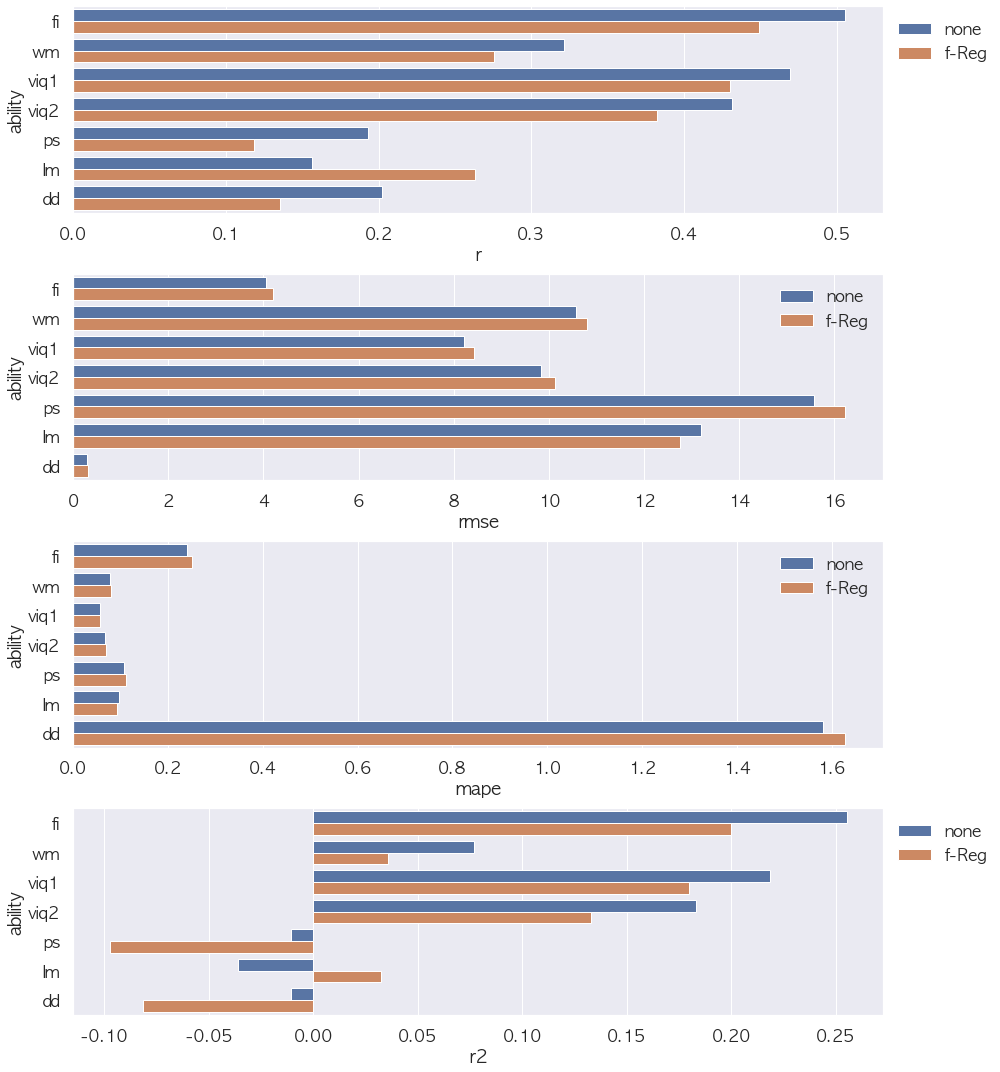

In [51]:
fig, axes = plt.subplots(4,1, figsize = [14,15])
g1 = sns.barplot(data=fs_fnl, y='ability', x ='r', hue = 'fs_method', ax = axes[0])
g1.legend(bbox_to_anchor=(1, 1))
g2 = sns.barplot(data=fs_fnl, y='ability', x ='rmse', hue = 'fs_method', ax = axes[1])
g2.legend(bbox_to_anchor=(1, 1))
g3 = sns.barplot(data=fs_fnl, y='ability', x ='mape', hue = 'fs_method', ax = axes[2])
g3.legend(bbox_to_anchor=(1, 1))
g4 = sns.barplot(data=fs_fnl, y='ability', x ='r2', hue = 'fs_method', ax = axes[3])
g4.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

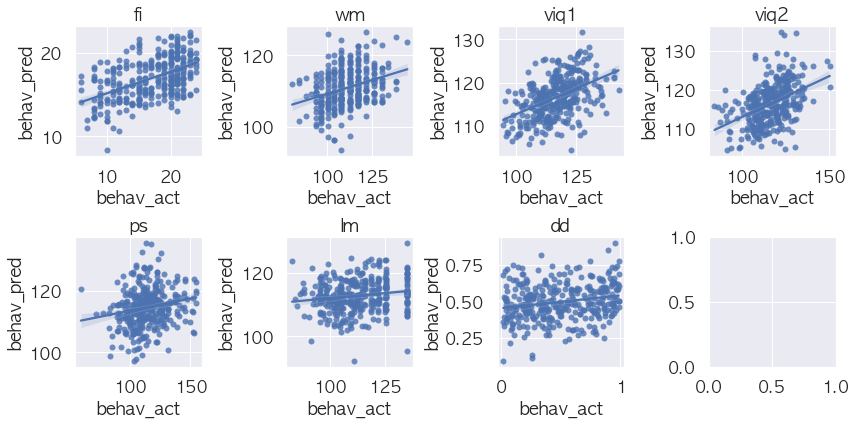

In [53]:
ax_list = [];
for i in range(2):
    for j in range(4):
        ax_list.append([int(i),int(j)])

fig, axes = plt.subplots(2,4, figsize = [12,6])
for idx, name in enumerate(b_type):
    tmp_df = fs_results.loc[(fs_results['fs'] == 'none') & (fs_results['ability'] == name), 
                            ['behav_act', 'behav_pred']]
    g=sns.regplot(x='behav_act', y='behav_pred', data=tmp_df, ax = axes[ax_list[idx][0], ax_list[idx][1]]);
    axes[ax_list[idx][0], ax_list[idx][1]].set_title(('%s' % name))
plt.tight_layout()
plt.show()

* 전반적으로 Feature Selection을 하지 않고, 모든 데이터를 활용하는 경우가 더 우수하다.
* WM sFC 데이터로 가장 우수한 예측력을 보이는 behavior 측정치는 Fluid Intelligence로 나타났다.

## Relationship between sFC and Cognitive Ability

* wm task 중 Network별 평균 FC value와 가장 관련성이 높은 행동 특성이 무엇인지 확인한다.
* 전체 edge를 8개 network 소속에 따라 분할하고, 행동 특성 7가지와 관련성을 확인한다.
* Outlier를 고려하여 Skipped Correlation을 확인한다.

In [85]:
edge_dat = pd.read_csv('%s/shen_edge_info.csv' % (hcp_dir))

In [86]:
net_list = ['Medial frontal', 'Fronto Parietal', 
            'Default Mode', 'Subcortical-cereb', 
            'Motor', 'Visual I', 'Visual II', 
            'Visual Association']

In [87]:
X_df = df_target.loc[:, '0':]
y_df = df_label.loc[:, 'fi':]

In [88]:
X_df = pd.concat([pd.DataFrame(edge_dat['net']), 
           X_df.T.reset_index(drop=True)], axis=1).T

In [89]:
X_df_1 = X_df.loc[0:, X_df.loc['net',:] == 1] 
X_df_2 = X_df.loc[0:, X_df.loc['net',:] == 2]
X_df_3 = X_df.loc[0:, X_df.loc['net',:] == 3]
X_df_4 = X_df.loc[0:, X_df.loc['net',:] == 4]
X_df_5 = X_df.loc[0:, X_df.loc['net',:] == 5]
X_df_6 = X_df.loc[0:, X_df.loc['net',:] == 6]
X_df_7 = X_df.loc[0:, X_df.loc['net',:] == 7]
X_df_8 = X_df.loc[0:, X_df.loc['net',:] == 8]

In [90]:
b_list = y_df.columns.values

### Fluid Intelligence & fcNet

In [91]:
targ_b = b_list[0]

res = pd.concat([pg.corr(X_df_1.mean(axis=1), y_df[targ_b], method='skipped'), pg.corr(X_df_2.mean(axis=1), y_df[targ_b], method='skipped'),
           pg.corr(X_df_3.mean(axis=1), y_df[targ_b], method='skipped'), pg.corr(X_df_4.mean(axis=1), y_df[targ_b], method='skipped'),
           pg.corr(X_df_5.mean(axis=1), y_df[targ_b], method='skipped'), pg.corr(X_df_6.mean(axis=1), y_df[targ_b], method='skipped'),
           pg.corr(X_df_7.mean(axis=1), y_df[targ_b], method='skipped'), pg.corr(X_df_8.mean(axis=1), y_df[targ_b], method='skipped')]).T
res.columns = [net_list[0], net_list[1], net_list[2], net_list[3],
              net_list[4], net_list[5], net_list[6], net_list[7]]
res.T

n outliers         r          CI95%     p-val     power
Medial frontal      337        0  0.222327   [0.12, 0.32]  0.000038  0.985292
Fronto Parietal     337        0  0.166537   [0.06, 0.27]   0.00216  0.867863
Default Mode        337        0  0.113654   [0.01, 0.22]  0.037032   0.55128
Subcortical-cereb   337        0  0.194986    [0.09, 0.3]  0.000317  0.951002
Motor               337        0  0.175335   [0.07, 0.28]   0.00123  0.900115
Visual I            337        0  0.284552   [0.18, 0.38]       0.0  0.999657
Visual II           337        0  0.009518   [-0.1, 0.12]  0.861805  0.053434
Visual Association  337        0  0.058013  [-0.05, 0.16]  0.288275  0.186009

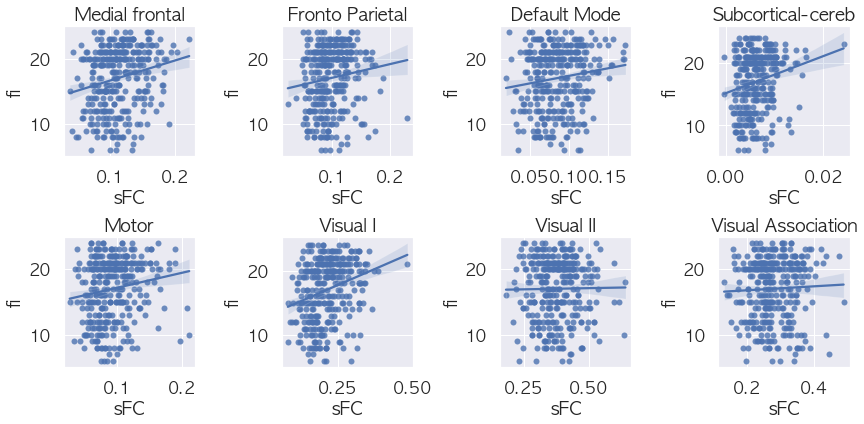

In [92]:
ax_list = [];
for i in range(2):
    for j in range(4):
        ax_list.append([int(i),int(j)])

fig, axes = plt.subplots(2,4, figsize = [12,6])
for idx, name in enumerate(net_list):
    tmp_x = eval(('X_df_%d' % (idx+1))).copy()
    tmp_df = pd.concat([tmp_x.mean(axis=1), y_df[targ_b]], axis = 1)
    tmp_df.columns = ['sFC', targ_b]
    g=sns.regplot(x='sFC', y=targ_b, data=tmp_df, ax = axes[ax_list[idx][0], ax_list[idx][1]]);
    axes[ax_list[idx][0], ax_list[idx][1]].set_title(('%s' % name))
plt.tight_layout()
plt.show()

### Working Memory & fcNet

In [93]:
targ_b = b_list[1]

res = pd.concat([pg.corr(X_df_1.mean(axis=1), y_df[targ_b], method='skipped'), pg.corr(X_df_2.mean(axis=1), y_df[targ_b], method='skipped'),
           pg.corr(X_df_3.mean(axis=1), y_df[targ_b], method='skipped'), pg.corr(X_df_4.mean(axis=1), y_df[targ_b], method='skipped'),
           pg.corr(X_df_5.mean(axis=1), y_df[targ_b], method='skipped'), pg.corr(X_df_6.mean(axis=1), y_df[targ_b], method='skipped'),
           pg.corr(X_df_7.mean(axis=1), y_df[targ_b], method='skipped'), pg.corr(X_df_8.mean(axis=1), y_df[targ_b], method='skipped')]).T
res.columns = [net_list[0], net_list[1], net_list[2], net_list[3],
              net_list[4], net_list[5], net_list[6], net_list[7]]
res.T

n outliers         r          CI95%     p-val     power
Medial frontal      337        0  0.166834   [0.06, 0.27]   0.00212  0.869057
Fronto Parietal     337        0  0.202749     [0.1, 0.3]  0.000179  0.964273
Default Mode        337        0  0.046052  [-0.06, 0.15]  0.399393  0.134545
Subcortical-cereb   337        0  0.120248   [0.01, 0.22]  0.027295  0.599187
Motor               337        0  0.198117    [0.09, 0.3]  0.000252  0.956759
Visual I            337        0  0.179025   [0.07, 0.28]  0.000964  0.911802
Visual II           337        0  0.047177  [-0.06, 0.15]  0.387967  0.138849
Visual Association  337        0 -0.012165  [-0.12, 0.09]  0.823928  0.055648

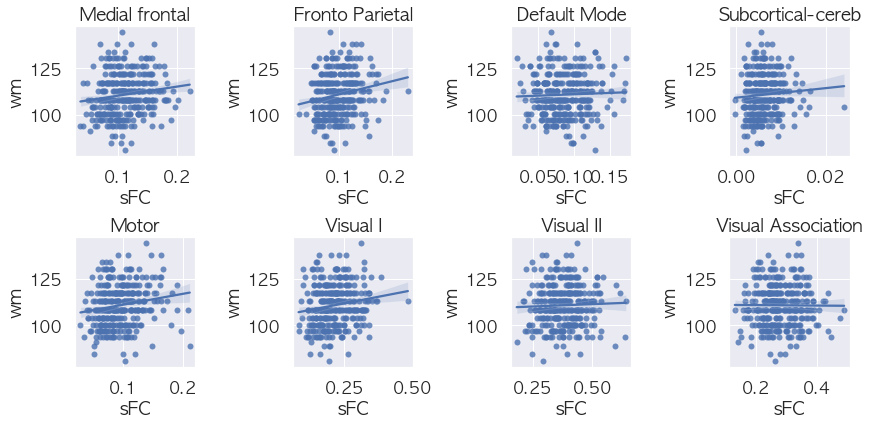

In [94]:
ax_list = [];
for i in range(2):
    for j in range(4):
        ax_list.append([int(i),int(j)])

fig, axes = plt.subplots(2,4, figsize = [12,6])
for idx, name in enumerate(net_list):
    tmp_x = eval(('X_df_%d' % (idx+1))).copy()
    tmp_df = pd.concat([tmp_x.mean(axis=1), y_df[targ_b]], axis = 1)
    tmp_df.columns = ['sFC', targ_b]
    g=sns.regplot(x='sFC', y=targ_b, data=tmp_df, ax = axes[ax_list[idx][0], ax_list[idx][1]]);
    axes[ax_list[idx][0], ax_list[idx][1]].set_title(('%s' % name))
plt.tight_layout()
plt.show()

### Verbal IQ 1 & fcNet

In [95]:
targ_b = b_list[2]

res = pd.concat([pg.corr(X_df_1.mean(axis=1), y_df[targ_b], method='skipped'), pg.corr(X_df_2.mean(axis=1), y_df[targ_b], method='skipped'),
           pg.corr(X_df_3.mean(axis=1), y_df[targ_b], method='skipped'), pg.corr(X_df_4.mean(axis=1), y_df[targ_b], method='skipped'),
           pg.corr(X_df_5.mean(axis=1), y_df[targ_b], method='skipped'), pg.corr(X_df_6.mean(axis=1), y_df[targ_b], method='skipped'),
           pg.corr(X_df_7.mean(axis=1), y_df[targ_b], method='skipped'), pg.corr(X_df_8.mean(axis=1), y_df[targ_b], method='skipped')]).T
res.columns = [net_list[0], net_list[1], net_list[2], net_list[3],
              net_list[4], net_list[5], net_list[6], net_list[7]]
res.T

n outliers         r          CI95%     p-val     power
Medial frontal      337        0  0.036903  [-0.07, 0.14]   0.49957  0.103654
Fronto Parietal     337        1  0.026135  [-0.08, 0.13]  0.633104  0.076469
Default Mode        337        1 -0.001856  [-0.11, 0.11]  0.972966  0.050084
Subcortical-cereb   337        0  0.102683   [-0.0, 0.21]  0.059701  0.470433
Motor               337        1  0.030647  [-0.08, 0.14]  0.575609  0.086598
Visual I            337        1   0.17799   [0.07, 0.28]   0.00105  0.907821
Visual II           337        1 -0.036262  [-0.14, 0.07]  0.507698  0.101603
Visual Association  337        1  0.132537   [0.03, 0.24]  0.015052  0.683014

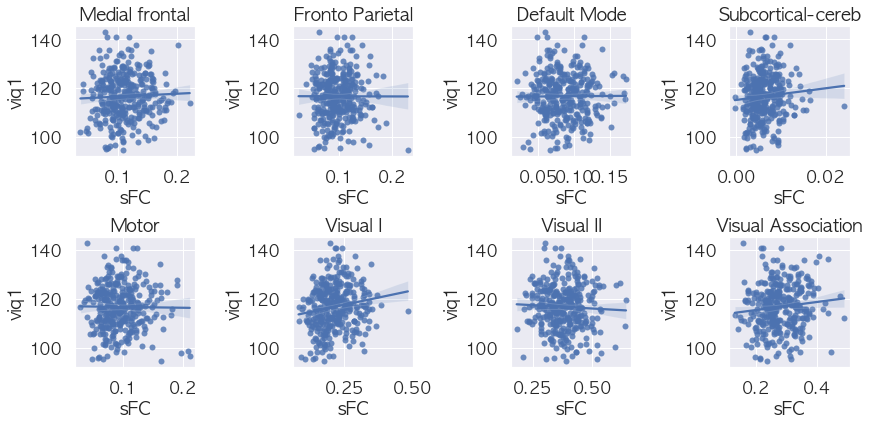

In [96]:
ax_list = [];
for i in range(2):
    for j in range(4):
        ax_list.append([int(i),int(j)])

fig, axes = plt.subplots(2,4, figsize = [12,6])
for idx, name in enumerate(net_list):
    tmp_x = eval(('X_df_%d' % (idx+1))).copy()
    tmp_df = pd.concat([tmp_x.mean(axis=1), y_df[targ_b]], axis = 1)
    tmp_df.columns = ['sFC', targ_b]
    g=sns.regplot(x='sFC', y=targ_b, data=tmp_df, ax = axes[ax_list[idx][0], ax_list[idx][1]]);
    axes[ax_list[idx][0], ax_list[idx][1]].set_title(('%s' % name))
plt.tight_layout()
plt.show()

### Verbal IQ 2 & fcNet

In [97]:
targ_b = b_list[3]

res = pd.concat([pg.corr(X_df_1.mean(axis=1), y_df[targ_b], method='skipped'), pg.corr(X_df_2.mean(axis=1), y_df[targ_b], method='skipped'),
           pg.corr(X_df_3.mean(axis=1), y_df[targ_b], method='skipped'), pg.corr(X_df_4.mean(axis=1), y_df[targ_b], method='skipped'),
           pg.corr(X_df_5.mean(axis=1), y_df[targ_b], method='skipped'), pg.corr(X_df_6.mean(axis=1), y_df[targ_b], method='skipped'),
           pg.corr(X_df_7.mean(axis=1), y_df[targ_b], method='skipped'), pg.corr(X_df_8.mean(axis=1), y_df[targ_b], method='skipped')]).T
res.columns = [net_list[0], net_list[1], net_list[2], net_list[3],
              net_list[4], net_list[5], net_list[6], net_list[7]]
res.T

n outliers         r          CI95%     p-val     power
Medial frontal      337        5  0.103018   [-0.0, 0.21]  0.060795  0.467253
Fronto Parietal     337        6  0.044381  [-0.06, 0.15]  0.420946  0.126912
Default Mode        337        6  0.013182  [-0.09, 0.12]  0.811156  0.056523
Subcortical-cereb   337        5  0.098195   [-0.01, 0.2]  0.073975  0.432265
Motor               337        5   0.11352   [0.01, 0.22]  0.038704  0.544106
Visual I            337        6  0.166918   [0.06, 0.27]  0.002313  0.863411
Visual II           337        6 -0.072465  [-0.18, 0.04]  0.188469  0.260411
Visual Association  337        5  0.055974  [-0.05, 0.16]  0.309227  0.174416

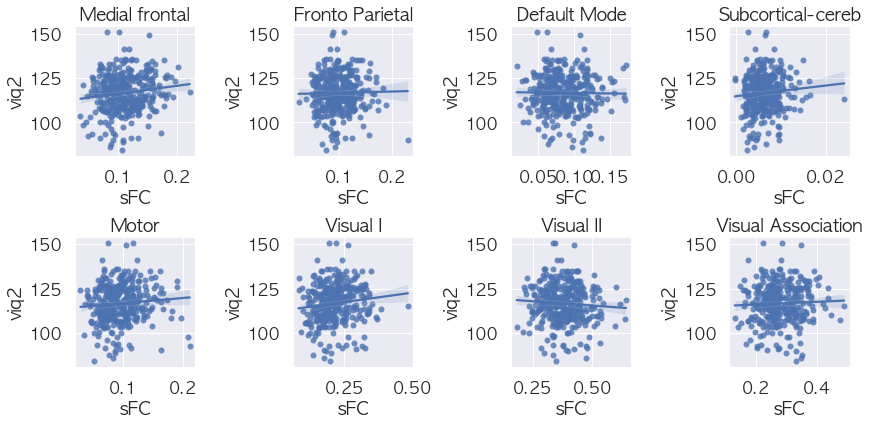

In [98]:
ax_list = [];
for i in range(2):
    for j in range(4):
        ax_list.append([int(i),int(j)])

fig, axes = plt.subplots(2,4, figsize = [12,6])
for idx, name in enumerate(net_list):
    tmp_x = eval(('X_df_%d' % (idx+1))).copy()
    tmp_df = pd.concat([tmp_x.mean(axis=1), y_df[targ_b]], axis = 1)
    tmp_df.columns = ['sFC', targ_b]
    g=sns.regplot(x='sFC', y=targ_b, data=tmp_df, ax = axes[ax_list[idx][0], ax_list[idx][1]]);
    axes[ax_list[idx][0], ax_list[idx][1]].set_title(('%s' % name))
plt.tight_layout()
plt.show()

### Processing Speed & fcNet

In [99]:
targ_b = b_list[4]

res = pd.concat([pg.corr(X_df_1.mean(axis=1), y_df[targ_b], method='skipped'), pg.corr(X_df_2.mean(axis=1), y_df[targ_b], method='skipped'),
           pg.corr(X_df_3.mean(axis=1), y_df[targ_b], method='skipped'), pg.corr(X_df_4.mean(axis=1), y_df[targ_b], method='skipped'),
           pg.corr(X_df_5.mean(axis=1), y_df[targ_b], method='skipped'), pg.corr(X_df_6.mean(axis=1), y_df[targ_b], method='skipped'),
           pg.corr(X_df_7.mean(axis=1), y_df[targ_b], method='skipped'), pg.corr(X_df_8.mean(axis=1), y_df[targ_b], method='skipped')]).T
res.columns = [net_list[0], net_list[1], net_list[2], net_list[3],
              net_list[4], net_list[5], net_list[6], net_list[7]]
res.T

n outliers         r          CI95%     p-val     power
Medial frontal      337        1  0.130074   [0.02, 0.23]  0.017054  0.666525
Fronto Parietal     337        1  0.192494   [0.09, 0.29]  0.000387  0.945416
Default Mode        337        1  0.026086  [-0.08, 0.13]   0.63374  0.076368
Subcortical-cereb   337        1  0.044225  [-0.06, 0.15]  0.419068  0.127552
Motor               337        1  0.101278  [-0.01, 0.21]  0.063696  0.459005
Visual I            337        1  0.102263   [-0.0, 0.21]  0.061146  0.466227
Visual II           337        5  0.100836  [-0.01, 0.21]  0.066495  0.451373
Visual Association  337        1  0.036772  [-0.07, 0.14]  0.501735  0.103102

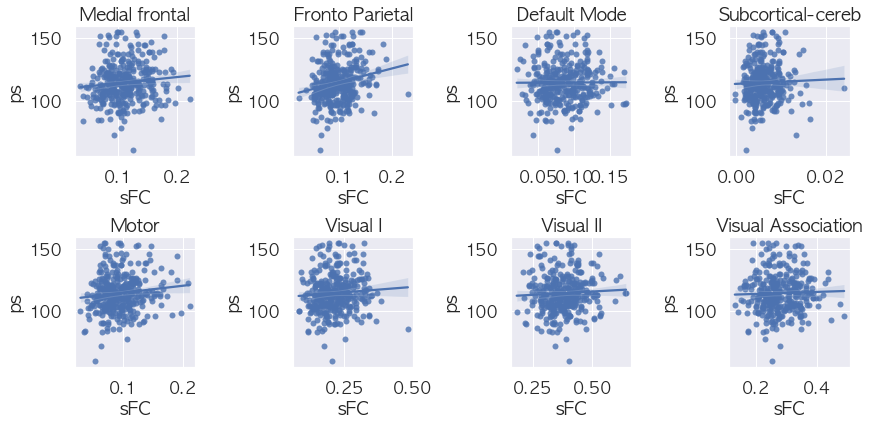

In [100]:
ax_list = [];
for i in range(2):
    for j in range(4):
        ax_list.append([int(i),int(j)])

fig, axes = plt.subplots(2,4, figsize = [12,6])
for idx, name in enumerate(net_list):
    tmp_x = eval(('X_df_%d' % (idx+1))).copy()
    tmp_df = pd.concat([tmp_x.mean(axis=1), y_df[targ_b]], axis = 1)
    tmp_df.columns = ['sFC', targ_b]
    g=sns.regplot(x='sFC', y=targ_b, data=tmp_df, ax = axes[ax_list[idx][0], ax_list[idx][1]]);
    axes[ax_list[idx][0], ax_list[idx][1]].set_title(('%s' % name))
plt.tight_layout()
plt.show()

### Episodic Memory & fcNet

In [101]:
targ_b = b_list[5]

res = pd.concat([pg.corr(X_df_1.mean(axis=1), y_df[targ_b], method='skipped'), pg.corr(X_df_2.mean(axis=1), y_df[targ_b], method='skipped'),
           pg.corr(X_df_3.mean(axis=1), y_df[targ_b], method='skipped'), pg.corr(X_df_4.mean(axis=1), y_df[targ_b], method='skipped'),
           pg.corr(X_df_5.mean(axis=1), y_df[targ_b], method='skipped'), pg.corr(X_df_6.mean(axis=1), y_df[targ_b], method='skipped'),
           pg.corr(X_df_7.mean(axis=1), y_df[targ_b], method='skipped'), pg.corr(X_df_8.mean(axis=1), y_df[targ_b], method='skipped')]).T
res.columns = [net_list[0], net_list[1], net_list[2], net_list[3],
              net_list[4], net_list[5], net_list[6], net_list[7]]
res.T

n outliers         r          CI95%     p-val     power
Medial frontal      337        0  0.043999  [-0.06, 0.15]  0.420759  0.126975
Fronto Parietal     337        0  0.012975  [-0.09, 0.12]  0.812418  0.056434
Default Mode        337        0  0.031307  [-0.08, 0.14]  0.566827   0.08834
Subcortical-cereb   337        0  0.129062   [0.02, 0.23]   0.01777  0.660956
Motor               337        0  0.113512   [0.01, 0.22]   0.03727   0.55024
Visual I            337        0  0.133082   [0.03, 0.24]  0.014491  0.687908
Visual II           337        0  0.017756  [-0.09, 0.12]  0.745351  0.062133
Visual Association  337        0  0.031031  [-0.08, 0.14]   0.57026  0.087653

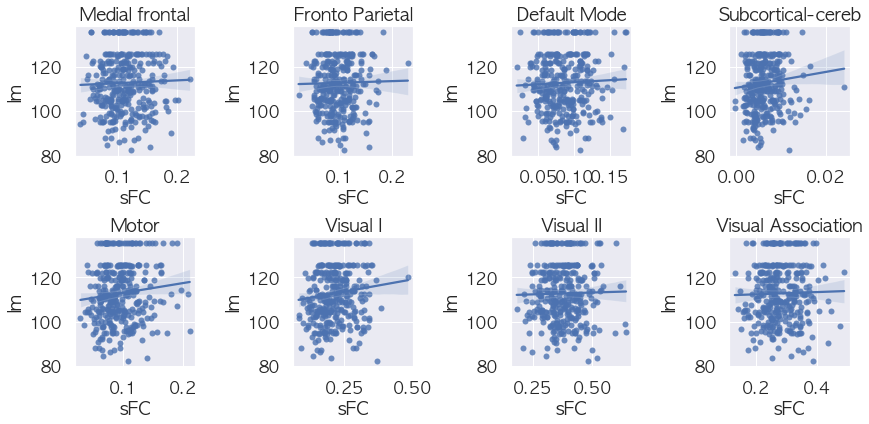

In [102]:
ax_list = [];
for i in range(2):
    for j in range(4):
        ax_list.append([int(i),int(j)])

fig, axes = plt.subplots(2,4, figsize = [12,6])
for idx, name in enumerate(net_list):
    tmp_x = eval(('X_df_%d' % (idx+1))).copy()
    tmp_df = pd.concat([tmp_x.mean(axis=1), y_df[targ_b]], axis = 1)
    tmp_df.columns = ['sFC', targ_b]
    g=sns.regplot(x='sFC', y=targ_b, data=tmp_df, ax = axes[ax_list[idx][0], ax_list[idx][1]]);
    axes[ax_list[idx][0], ax_list[idx][1]].set_title(('%s' % name))
plt.tight_layout()
plt.show()

### Delay Discounting & fcNet

In [103]:
targ_b = b_list[6]

res = pd.concat([pg.corr(X_df_1.mean(axis=1), y_df[targ_b], method='skipped'), pg.corr(X_df_2.mean(axis=1), y_df[targ_b], method='skipped'),
           pg.corr(X_df_3.mean(axis=1), y_df[targ_b], method='skipped'), pg.corr(X_df_4.mean(axis=1), y_df[targ_b], method='skipped'),
           pg.corr(X_df_5.mean(axis=1), y_df[targ_b], method='skipped'), pg.corr(X_df_6.mean(axis=1), y_df[targ_b], method='skipped'),
           pg.corr(X_df_7.mean(axis=1), y_df[targ_b], method='skipped'), pg.corr(X_df_8.mean(axis=1), y_df[targ_b], method='skipped')]).T
res.columns = [net_list[0], net_list[1], net_list[2], net_list[3],
              net_list[4], net_list[5], net_list[6], net_list[7]]
res.T

n outliers         r          CI95%     p-val     power
Medial frontal      337        1  0.181281   [0.08, 0.28]  0.000843  0.917677
Fronto Parietal     337        5 -0.026654  [-0.13, 0.08]  0.628441  0.077212
Default Mode        337        4  0.116955   [0.01, 0.22]  0.032882  0.570337
Subcortical-cereb   337        0  0.076596  [-0.03, 0.18]   0.16063  0.289592
Motor               337        8  0.042956  [-0.07, 0.15]  0.437423  0.121474
Visual I            337        2   0.17713   [0.07, 0.28]  0.001131   0.90428
Visual II           337        5  0.002841   [-0.1, 0.11]  0.958869  0.050257
Visual Association  337        2  0.028842  [-0.08, 0.14]  0.598865  0.082243

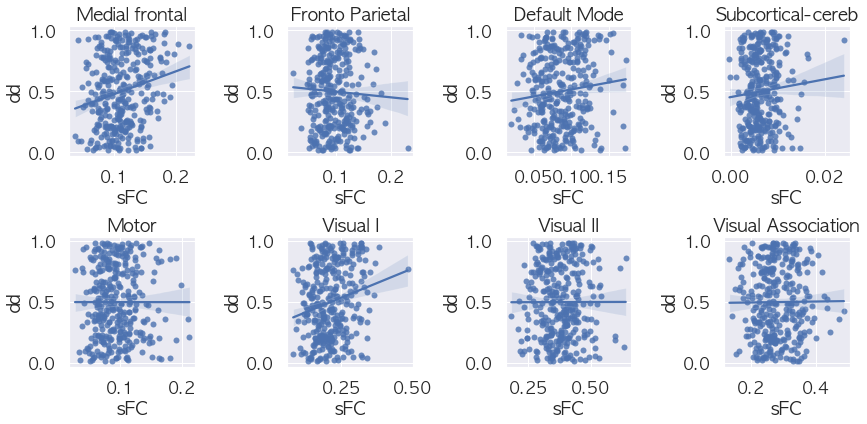

In [104]:
ax_list = [];
for i in range(2):
    for j in range(4):
        ax_list.append([int(i),int(j)])

fig, axes = plt.subplots(2,4, figsize = [12,6])
for idx, name in enumerate(net_list):
    tmp_x = eval(('X_df_%d' % (idx+1))).copy()
    tmp_df = pd.concat([tmp_x.mean(axis=1), y_df[targ_b]], axis = 1)
    tmp_df.columns = ['sFC', targ_b]
    g=sns.regplot(x='sFC', y=targ_b, data=tmp_df, ax = axes[ax_list[idx][0], ax_list[idx][1]]);
    axes[ax_list[idx][0], ax_list[idx][1]].set_title(('%s' % name))
plt.tight_layout()
plt.show()

### Summary

In [105]:
sumDF = pd.DataFrame()
for b_idx, b_name in enumerate(b_list):
    for n_idx, n_name in enumerate(net_list):
        tmp_x = eval(('X_df_%d' % (n_idx+1))).copy()
        tmp_corr = pg.corr(tmp_x.mean(axis=1), y_df[b_name])
        tmp_corr = pd.concat([pd.DataFrame({'behav':b_list[b_idx], 'net':[net_list[n_idx]]}), tmp_corr.reset_index()], axis = 1)
        sumDF = sumDF.append(tmp_corr)


In [106]:
sumDF.sort_values('p-val').head(5)

behav              net    index    n         r         CI95%         p-val  \
0    fi         Visual I  pearson  337  0.266568  [0.16, 0.36]  6.852964e-07   
0    fi   Medial frontal  pearson  337  0.213045  [0.11, 0.31]  8.086904e-05   
0    dd   Medial frontal  pearson  337  0.209698  [0.11, 0.31]  1.051257e-04   
0    ps  Fronto Parietal  pearson  337  0.207104   [0.1, 0.31]  1.284594e-04   
0    dd         Visual I  pearson  337  0.204123    [0.1, 0.3]  1.612497e-04   

       BF10     power  
0  1.46e+04  0.998814  
0   155.968  0.977225  
0   121.874  0.973530  
0   100.965  0.970337  
0    81.584  0.966286

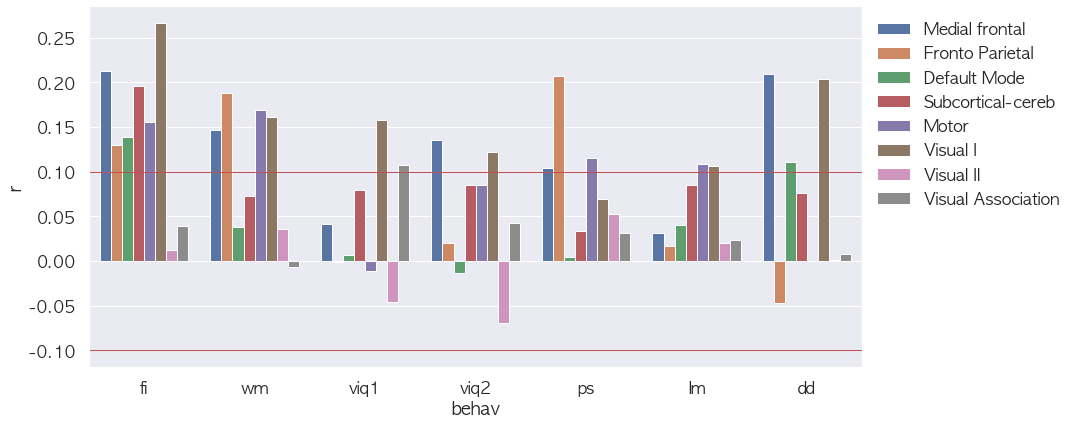

In [107]:
plt.subplots(figsize=[15,6])
sns.barplot(data=sumDF, x='behav', y='r', hue='net')
plt.axhline(y=0.10, color='r', linewidth=1)
plt.axhline(y=-0.10, color='r', linewidth=1)
plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

* CPM 결과와 동일하게, WM task 중 Network별 평균 FC value와 가장 관련성이 높은 행동 특성은 fluid intelligence이다.
* 특히, Visual I, Medial Frontal, Subcortical 내의 연결성이 가장 관련성이 높았다. 

## Network Analysis

* 전체 네트워크 수준에서의 특성과 Fluid intelligence 간의 관계를 확인한다.
* Network analysis 기법을 활용. 전체 네트워크의 segregation 지표로 Modularity, integration 지표로 global efficiency를 사용한다.

In [77]:
import bct

net_df = [];
md = [];
ge = [];
act = [];

for idx, name in enumerate(list(df_label.sn.values)):
    X_df = df_target.loc[idx, '0':].values
    y_df = df_label.loc[idx, 'fi']
    X_mat = sp.spatial.distance.squareform(X_df)
    X_mat_pos = deepcopy(X_mat)
    X_mat_pos[X_mat < 0] = 0
    
    M1, q1 = bct.community_louvain(W=X_mat, gamma=1, B='negative_asym', seed=22)
    
    ge1 = bct.efficiency_wei(X_mat_pos, local=False)

    
    md.append(q1)
    ge.append(ge1)
    act.append(y_df)
    
    

net_df = pd.DataFrame({'modularity': md,
                       'g_efficiency' : ge,
                       'behav_act': act})
    

In [78]:
pg.corr(data=net_df, x=net_df.modularity, y=net_df.behav_act)

n         r          CI95%     p-val   BF10     power
pearson  337  0.100778  [-0.01, 0.21]  0.064622  0.373  0.456441

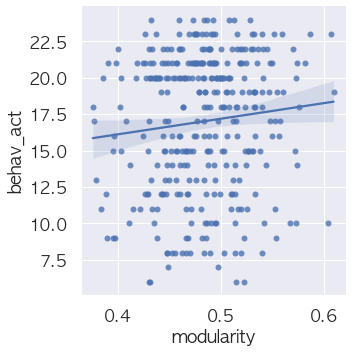

In [79]:
sns.lmplot(data =net_df, x='modularity', y='behav_act')

In [80]:
pg.corr(data=net_df, x=net_df.g_efficiency, y=net_df.behav_act)

n         r         CI95%     p-val    BF10     power
pearson  337  0.190899  [0.09, 0.29]  0.000425  32.998  0.942597

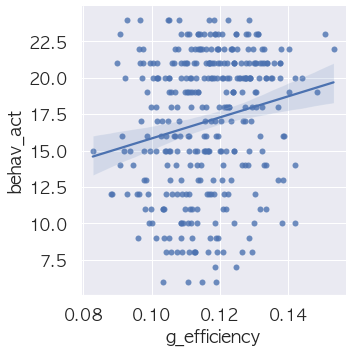

In [81]:
sns.lmplot(data =net_df, x='g_efficiency', y='behav_act')

* Fluid Intelligence와 관련성이 큰 네트워크 지표는 Global Efficiency 였다.

# KBRI dataset

* HCP 데이터를 활용한 모델링의 기법을 사용하여, Sustained Attention 능력과 rest / task state의 sFC 간의 관계를 모델링한다.

## Data Load

In [4]:
proj_dir=os.getcwd()
kbri_dir=(proj_dir +  '/kbri_data')

In [5]:
os.listdir(kbri_dir)

['.DS_Store',
 'susAtt_behav.xlsx',
 'shen_edge_info.csv',
 'susAtt_behav.csv',
 'sFC_edge_summary.csv']

In [6]:
# behav data
behav_dat = pd.read_csv('%s/susAtt_behav.csv' % (kbri_dir))

# fMRI data
fMRI_dat = pd.read_csv('%s/sFC_edge_summary.csv' % (kbri_dir))

In [7]:
behav_dat.shape, fMRI_dat.shape

((12, 4), (858672, 7))

In [8]:
behav_dat.head(3)

sn    dprime  aprime      c
0   2  1.850727   0.803 -1.635
1   3  2.504125   0.889 -1.056
2   4  3.609470   0.971 -0.539

* sn : 참가자 번호
* dprime : gradCPT d-prime
* aprime : gradCPT a-prime
* c : gradCPT criterion

<br>

* *signal detection measure 참조 [[ref]](https://neuropsychology.github.io/psycho.R/2018/03/29/SDT.html)*

In [9]:
fMRI_dat.head(3)

sn  type  net  edge_from  edge_to      corr    corr_z
0   2  rest    0          1        2  0.087596  0.087821
1   2  rest    0          1        3  0.448782  0.483174
2   2  rest    2          1        4 -0.104997 -0.105386

* sn : 참가자 번호
* type : fMRI session (rest & task)
* net : brain network info, 0-8, 0 - between networks
* edge_from : node from, 1-267
* edge_to : node to, 2-268
* corr : sFC value
* corr_z : fisher's z transformed sFC value

## EDA

In [10]:
df_target = fMRI_dat.copy()
df_label = behav_dat.copy()

### data type

In [14]:
df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858672 entries, 0 to 858671
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   sn         858672 non-null  int64  
 1   type       858672 non-null  object 
 2   net        858672 non-null  int64  
 3   edge_from  858672 non-null  int64  
 4   edge_to    858672 non-null  int64  
 5   corr       858672 non-null  float64
 6   corr_z     858672 non-null  float64
dtypes: float64(2), int64(4), object(1)
memory usage: 45.9+ MB


In [15]:
df_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sn      12 non-null     int64  
 1   dprime  12 non-null     float64
 2   aprime  12 non-null     float64
 3   c       12 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 512.0 bytes


### Check NaN

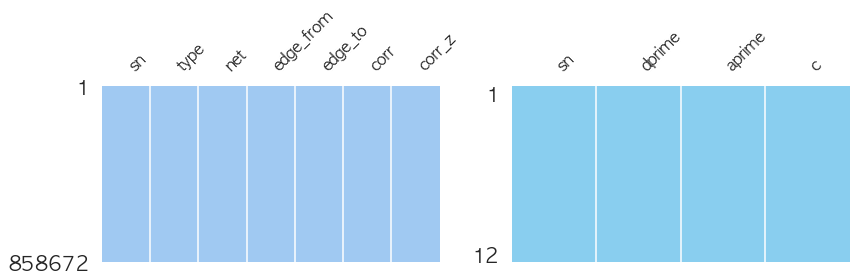

In [16]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
msno.matrix(df=df_target, color=(0.63, 0.79, 0.95), ax=axes[0])
msno.matrix(df=df_label, color=(0.54, 0.81, 0.94), ax=axes[1])
plt.tight_layout()
plt.show()

### Check Distribution

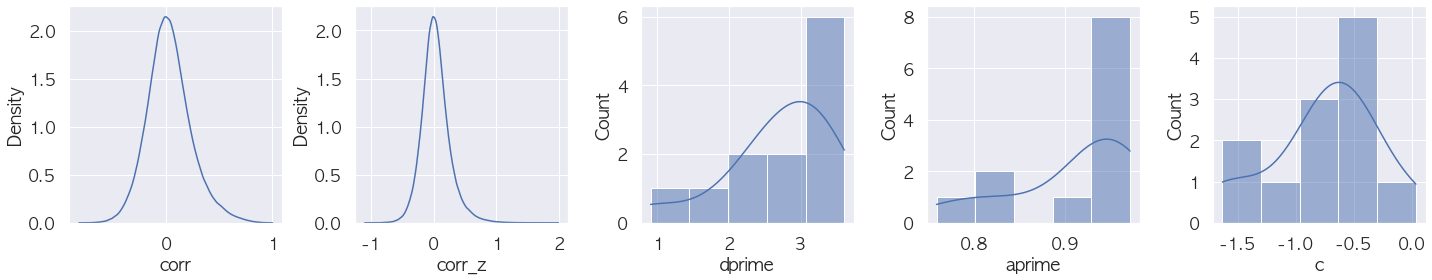

In [18]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
sns.kdeplot(data=df_target['corr'], ax=axes[0])
sns.kdeplot(data=df_target['corr_z'], ax=axes[1])
sns.histplot(data=df_label['dprime'], kde=True, ax=axes[2])
sns.histplot(data=df_label['aprime'], kde=True, ax=axes[3])
sns.histplot(data=df_label['c'], kde=True, ax=axes[4])
plt.tight_layout()
plt.show()

### Check Outliers

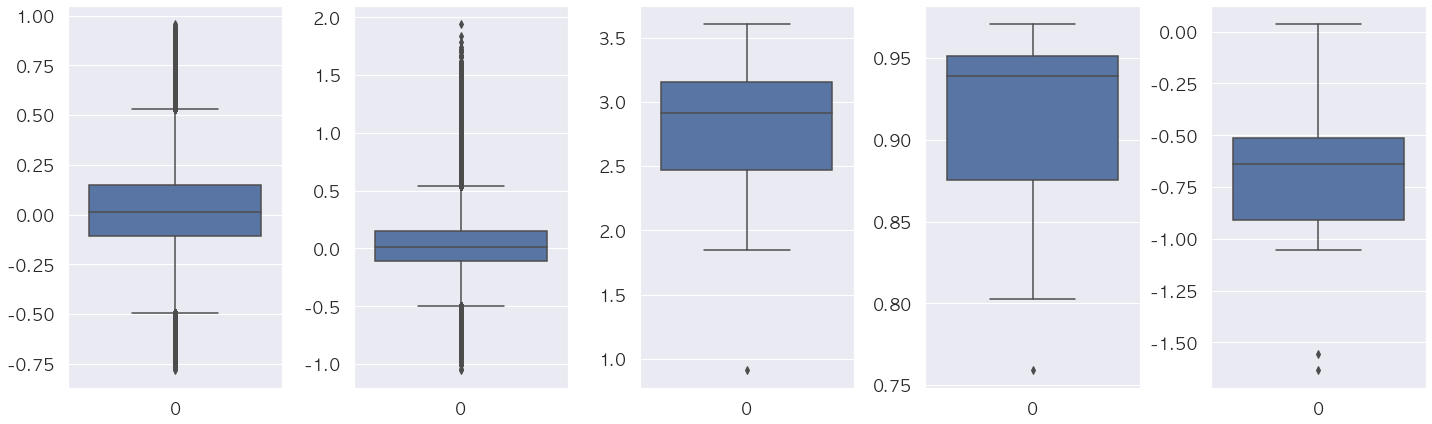

In [19]:
fig, axes = plt.subplots(1, 5, figsize=(20, 6))
sns.boxplot(data=df_target['corr'], ax=axes[0])
sns.boxplot(data=df_target['corr_z'], ax=axes[1])
sns.boxplot(data=df_label['dprime'], ax=axes[2])
sns.boxplot(data=df_label['aprime'], ax=axes[3])
sns.boxplot(data=df_label['c'], ax=axes[4])
plt.tight_layout()
plt.show()

## Preprocessing

<br>

### prepare FC data

In [20]:
sfc = fMRI_dat.loc[:,['sn','net','type','corr_z']]

In [21]:
# 컬럼에서 조건에 따른 로지컬 인덱스 생성
is_rest = (sfc['type'] == 'rest')
is_task = (sfc['type'] == 'task')

# 조건에 따라 데이터 추출
sfc_rest = sfc[is_rest]
sfc_task = sfc[is_task]

# 인덱스 열 추가
sfc_rest.insert(2, 'idx', 0)
sfc_task.insert(2, 'idx', 0)

# 인덱스 추가하기
for i in range(2,14):
    sfc_rest.loc[sfc_rest["sn"] == i, "idx"] = list(range(1,sfc_rest.loc[sfc_rest["sn"] == i, "idx"].shape[0]+1))
    sfc_task.loc[sfc_task["sn"] == i, "idx"] = list(range(1,sfc_task.loc[sfc_task["sn"] == i, "idx"].shape[0]+1))
    
# FC 데이터 포맷 변경 (long to wide format)
sfc_rest_w = sfc_rest.pivot(index='sn', columns='idx', values='corr_z')
sfc_task_w = sfc_task.pivot(index='sn', columns='idx', values='corr_z')

In [22]:
sfc_rest_w.shape, sfc_task_w.shape

((12, 35778), (12, 35778))

In [23]:
sfc_rest_w.head(3)

idx     1         2         3         4         5         6         7      \
sn                                                                          
2    0.087821  0.483174 -0.105386  0.536837  0.206530  0.409045  0.018217   
3    0.365570  0.340672  0.451663  0.311039  0.588303  0.203916  0.210759   
4    0.099487 -0.049594 -0.032397 -0.141527  0.890119 -0.199865 -0.291729   

idx     8         9         10     ...     35769     35770     35771  \
sn                                 ...                                 
2    0.039137  0.259211  0.052181  ... -0.053328  0.123742 -0.240273   
3    0.318436  0.682319  0.215890  ...  0.403547  0.169584  0.035766   
4   -0.092610  0.172806 -0.164627  ...  0.070985 -0.059494 -0.093339   

idx     35772     35773     35774     35775     35776     35777     35778  
sn                                                                         
2   -0.065108  0.260724  0.079251  0.089720  0.295782  0.547787  0.336801  
3    0.056895  0.523675  0.435298  0.402791  0.288749  0.325626  0.382869  
4   -0.177318  0.315748  0.275152  0.104687  0.503104  0.244396  0.223115  

[3 rows x 35778 columns]

### prepare Behavior Data

In [24]:
# Behavioural 데이터 포맷 변경 (long to wide format)
behav_dat_w = behav_dat

In [25]:
behav_dat_w.head(3)

sn    dprime  aprime      c
0   2  1.850727   0.803 -1.635
1   3  2.504125   0.889 -1.056
2   4  3.609470   0.971 -0.539

### Check Distribution & Outliers

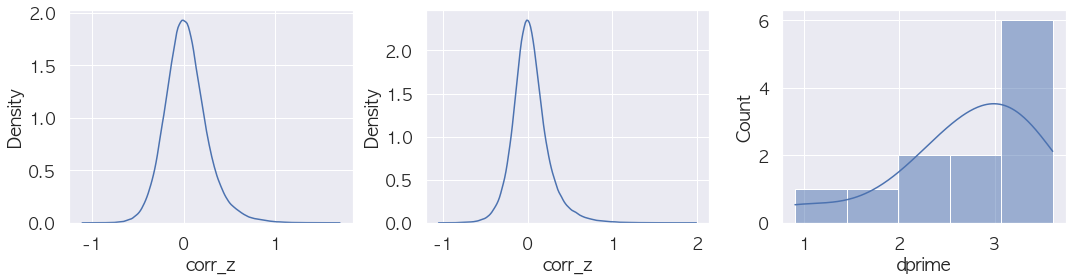

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.kdeplot(data=sfc_rest['corr_z'], ax=axes[0])
sns.kdeplot(data=sfc_task['corr_z'], ax=axes[1])
sns.histplot(data=behav_dat_w['dprime'], kde=True, ax=axes[2])
plt.tight_layout()
plt.show()

In [27]:
def outlier_check(df, method=1):

    if method == 1:  # Boxplot Method
        Q1 = df.quantile(0.25)
        Q3 = df.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1-(IQR*1.5)
        upper = Q1+(IQR*1.5)

    elif method == 2:  # Normal Distribution Method
        Mean = df.mean()
        std = df.std()
        lower = Mean-std*3
        upper = Mean+std*3

    out_mask = ((df < lower) | (df > upper))
    out_info = pd.concat([pd.DataFrame(lower, columns=['lower']),
                          pd.DataFrame(upper, columns=['upper']),
                          pd.DataFrame(df.min(), columns=['min']),
                          pd.DataFrame(df.max(), columns=['max']),
                          pd.DataFrame(((df < lower) | (df > upper)).sum(), columns=['counts'])], axis=1)
    return out_info, out_mask

In [28]:
rest_info, rest_mask = outlier_check(pd.DataFrame(sfc_rest['corr_z']), 2)
task_info, task_mask = outlier_check(pd.DataFrame(sfc_rest['corr_z']), 2)
behav_info, behav_mask = outlier_check(pd.DataFrame(behav_dat['dprime']), 2)

In [29]:
rest_info

lower     upper       min       max  counts
corr_z -0.672815  0.729428 -1.055361  1.655876    4194

In [30]:
task_info

lower     upper       min       max  counts
corr_z -0.672815  0.729428 -1.055361  1.655876    4194

In [32]:
behav_info

lower     upper      min      max  counts
dprime  0.468664  4.932341  0.90884  3.60947       0

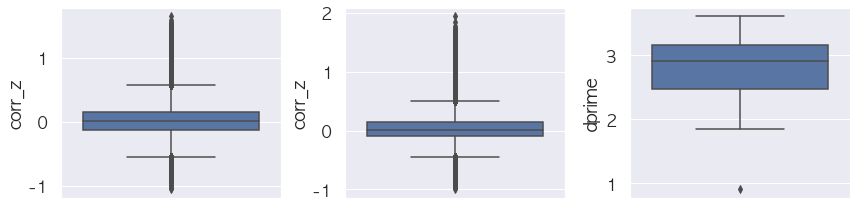

In [106]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
sns.boxplot(y=sfc_rest['corr_z'], ax=axes[0])
sns.boxplot(y=sfc_task['corr_z'], ax=axes[1])
sns.boxplot(y=behav_dat_w['dprime'], ax=axes[2])
plt.tight_layout()
plt.show()

In [33]:
rest_np = np.array(sfc_rest_w)
task_np = np.array(sfc_task_w)
behav_np = np.array(behav_dat_w['dprime'])
rest_np.shape, task_np.shape, behav_np.shape

((12, 35778), (12, 35778), (12,))

### Visualization

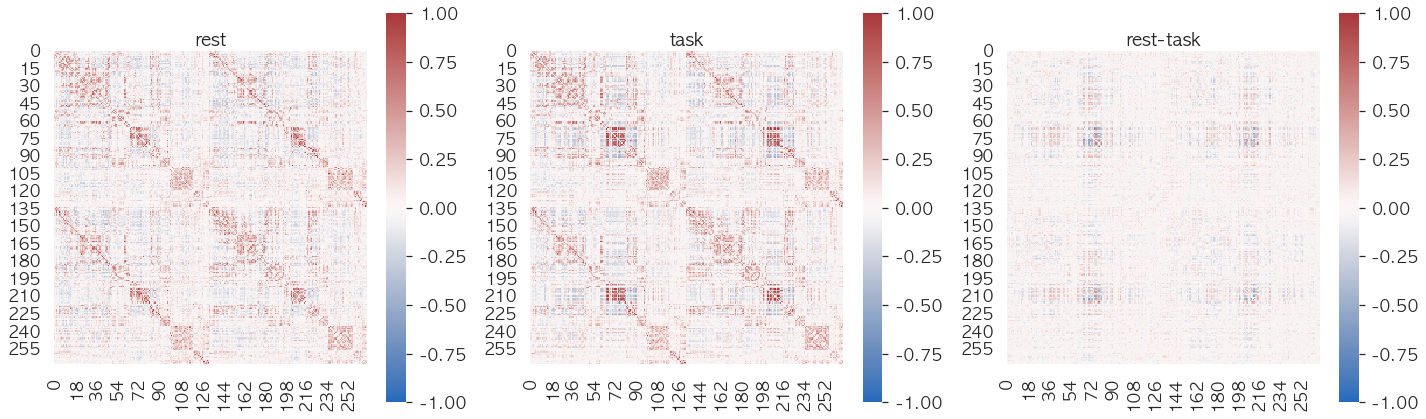

In [39]:
fig, axes = plt.subplots(1, 3, figsize=[20, 6])

g1 = sns.heatmap(sp.spatial.distance.squareform(np.mean(rest_np, axis=0)),
                 vmax=1, vmin=-1, 
                 square=True, cmap="vlag",
                 linecolor='white', ax = axes[0])
g1.set_title('rest')
g2 = sns.heatmap(sp.spatial.distance.squareform(np.mean(task_np, axis=0)),
                 vmax=1, vmin=-1, 
                 square=True, cmap="vlag",
                 linecolor='white', ax = axes[1])
g2.set_title('task')

diff_np = rest_np - task_np
g3 = sns.heatmap(sp.spatial.distance.squareform(np.mean(diff_np, axis=0)),
                 vmax=1, vmin=-1, 
                 square=True, cmap="vlag",
                 linecolor='white', ax = axes[2])
g3.set_title('rest-task')
plt.tight_layout()
plt.show()

## Feature Engineering

### Auto Feature Scaling & Selection

In [40]:
subj_idx = [2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]

In [41]:
rest_df = sfc_rest_w.copy()
task_df = sfc_task_w.copy()
behav_df = behav_dat_w[['sn', 'dprime']]
df_target_t = task_df.reset_index()
df_target_r = rest_df.reset_index()
df_label = behav_df

In [111]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import VarianceThreshold, mutual_info_regression, f_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.cross_decomposition import PLSRegression

# fs_method = ['none', 'VarThr', 'InfGain', 'f-Reg']
fs_method = ['none', 'f-Reg']
# 0 - none, 1 - variance Threshold, 2 - Information Gain, 3 - F-regression


fs_results = [];
x_fs = [];
x_tSn = [];
x_tSn_act = [];
x_tSn_r_pred = [];
x_tSn_t_pred = [];
x_nFeature_r = [];
x_nFeature_t = [];

for fs_idx, fs_name in enumerate(fs_method):
    
    print("%d. method %s processing ----------------------------\n\n" % (fs_idx+1, fs_name))
    for idx, this_sub in enumerate(subj_idx):

        # subject index
        train_subj = deepcopy(subj_idx)
        train_subj.remove(this_sub)
        test_subj = this_sub                                   

        # prepare data             df_target_r.loc[df_target_r['sn'] != 2, 1:]
        X_train_r = df_target_r.loc[df_target_r['sn'] != test_subj, 1:]
        X_train_t = df_target_t.loc[df_target_t['sn'] != test_subj, 1:]        
        y_train = df_label.loc[df_label['sn'] != test_subj, 'dprime']

        X_test_r = df_target_r.loc[df_target_r['sn'] == test_subj, 1:]
        X_test_t = df_target_t.loc[df_target_t['sn'] == test_subj, 1:]
        y_test = df_label.loc[df_label['sn'] == test_subj, 'dprime']
        
        # feature scaling 
        scaler_r = StandardScaler()
        targ_col_r = X_train_r.columns.values
        X_train_r = scaler_r.fit_transform(X_train_r)
        X_train_r = pd.DataFrame(X_train_r)
        X_train_r.columns = targ_col_r
        X_test_r = scaler_r.transform(X_test_r)
        X_test_r = pd.DataFrame(X_test_r)
        X_test_r.columns = targ_col_r

        scaler_t = StandardScaler()
        targ_col_t = X_train_t.columns.values
        X_train_t = scaler_t.fit_transform(X_train_t)
        X_train_t = pd.DataFrame(X_train_t)
        X_train_t.columns = targ_col_t
        X_test_t = scaler_r.transform(X_test_t)
        X_test_t = pd.DataFrame(X_test_t)
        X_test_t.columns = targ_col_t
        
        
        # feature selection
        if fs_name == 'none':
            
            X_train_r_fs = np.array(X_train_r)
            X_test_r_fs = np.array(X_test_r)

            X_train_t_fs = np.array(X_train_t)
            X_test_t_fs = np.array(X_test_t)
            
            y_train_fs = np.array(y_train)
            y_test_fs = np.array(y_test)
            
        elif fs_name == 'VarThr': # Variance Threshold
            
            Threshold = 0.2
            selector_var_r=VarianceThreshold(threshold=Threshold)
            selector_var_r.fit(X_train_r)            
            is_support_var_r = selector_var_r.variances_ > Threshold            
            X_train_r_fs = np.array(X_train_r[X_train_r.columns[is_support_var_r].values])
            X_test_r_fs = np.array(X_test_r[X_test_r.columns[is_support_var_r].values])
            
            selector_var_t=VarianceThreshold(threshold=Threshold)
            selector_var_t.fit(X_train_t)            
            is_support_var_t = selector_var_t.variances_ > Threshold            
            X_train_t_fs = np.array(X_train_t[X_train_t.columns[is_support_var_t].values])
            X_test_t_fs = np.array(X_test_t[X_test_t.columns[is_support_var_t].values])
            
            y_train_fs = np.array(y_train)
            y_test_fs = np.array(y_test)            
            
        elif fs_name == 'InfGain': # Information Gain
            
            Threshold = 0.02
            selector_ifg_r=SelectKBest(mutual_info_regression, k='all')
            selector_ifg_r.fit(X_train_r, y_train)
            is_support_ifg_r = selector_ifg_r.scores_ > Threshold
            X_train_r_fs = np.array(X_train_r[X_train_r.columns[is_support_ifg_r].values])
            X_test_r_fs = np.array(X_test_r[X_test_r.columns[is_support_ifg_r].values])

            selector_ifg_t=SelectKBest(mutual_info_regression, k='all')
            selector_ifg_t.fit(X_train_t, y_train)
            is_support_ifg_t = selector_ifg_t.scores_ > Threshold
            X_train_t_fs = np.array(X_train_t[X_train_t.columns[is_support_ifg_t].values])
            X_test_t_fs = np.array(X_test_t[X_test_t.columns[is_support_ifg_t].values])
            
            y_train_fs = np.array(y_train)
            y_test_fs = np.array(y_test)
            
        elif fs_name == 'f-Reg':
            
            Threshold = 0.05
            selector_freg_r=SelectKBest(f_regression, k='all')
            selector_freg_r.fit(X_train_r, y_train)
            is_support_freg_r = selector_freg_r.pvalues_ < Threshold
            X_train_r_fs = np.array(X_train_r[X_train_r.columns[is_support_freg_r].values])
            X_test_r_fs = np.array(X_test_r[X_test_r.columns[is_support_freg_r].values])

            selector_freg_t=SelectKBest(f_regression, k='all')
            selector_freg_t.fit(X_train_t, y_train)
            is_support_freg_t = selector_freg_t.pvalues_ < Threshold
            X_train_t_fs = np.array(X_train_t[X_train_t.columns[is_support_freg_t].values])
            X_test_t_fs = np.array(X_test_t[X_test_t.columns[is_support_freg_t].values])            
            
            y_train_fs = np.array(y_train)
            y_test_fs = np.array(y_test)
            
        #model_r = Ridge()
        model_r = Ridge()
        model_r.fit(X_train_r_fs, y_train_fs)
        y_pred_r = model_r.predict(X_test_r_fs) 
        
        model_t = Ridge()
        model_t.fit(X_train_t_fs, y_train_fs)
        y_pred_t = model_t.predict(X_test_t_fs)         
                
        x_fs.append(fs_name)
        x_tSn.append(this_sub)
        x_tSn_act.append(y_test_fs[0]);
        x_tSn_r_pred.append(y_pred_r[0]); 
        x_tSn_t_pred.append(y_pred_t[0]);        
        x_nFeature_r.append(X_train_r_fs.shape[1])
        x_nFeature_t.append(X_train_t_fs.shape[1])
        
    print("%d. method %s done ----------------------------\n\n" % (fs_idx+1, fs_name))

fs_results = pd.DataFrame({'fs_method': x_fs,
                           'tSN': x_tSn,
                           'behav_act': x_tSn_act,                            
                           'behav_pred_r': x_tSn_r_pred,
                           'behav_pred_t': x_tSn_t_pred,
                           'nFeature_r': x_nFeature_r,
                           'nFeature_t': x_nFeature_t})

1. method none processing ----------------------------


1. method none done ----------------------------


2. method f-Reg processing ----------------------------


2. method f-Reg done ----------------------------




In [112]:
fs_results

fs_method  tSN  behav_act  behav_pred_r  behav_pred_t  nFeature_r  \
0       none    2   1.850727      2.716493      2.837457       35778   
1       none    3   2.504125      2.852289      2.952566       35778   
2       none    4   3.609470      2.408284      2.658876       35778   
3       none    5   3.132076      2.522827      2.556993       35778   
4       none    6   3.292870      2.648825      2.821549       35778   
5       none    7   2.726137      2.806323      2.931099       35778   
6       none    8   3.236010      2.681428      2.672097       35778   
7       none    9   3.096713      2.732247      2.786078       35778   
8       none   10   3.122660      2.727342      2.589718       35778   
9       none   11   2.559771      2.854476      2.775192       35778   
10      none   12   2.366633      2.863013      3.000740       35778   
11      none   13   0.908840      2.863300      2.900538       35778   
12     f-Reg    2   1.850727      2.730993      2.892313        1500   
13     f-Reg    3   2.504125      2.805360      2.977662        1711   
14     f-Reg    4   3.609470      2.436427      2.631878        1830   
15     f-Reg    5   3.132076      2.567411      2.588805        1711   
16     f-Reg    6   3.292870      2.715436      2.828534        1530   
17     f-Reg    7   2.726137      2.854476      2.936176        1718   
18     f-Reg    8   3.236010      2.647498      2.622482        1627   
19     f-Reg    9   3.096713      2.769266      2.738789        1561   
20     f-Reg   10   3.122660      2.724660      2.553300        1588   
21     f-Reg   11   2.559771      2.810588      2.835763        1599   
22     f-Reg   12   2.366633      2.840279      3.061159        1660   
23     f-Reg   13   0.908840      2.859096      2.970813        1344   

    nFeature_t  
0        35778  
1        35778  
2        35778  
3        35778  
4        35778  
5        35778  
6        35778  
7        35778  
8        35778  
9        35778  
10       35778  
11       35778  
12        3582  
13        3346  
14        3218  
15        3253  
16        2890  
17        3196  
18        3107  
19        3000  
20        3194  
21        3130  
22        3493  
23        1323

In [113]:
fs_method = ['none', 'f-Reg']

x_fs = [];
x_corr_r = [];
x_corr_p_r = [];
x_rmse_r = [];
x_mape_r = [];
x_nf_r = [];
x_corr_t = [];
x_corr_p_t = [];
x_rmse_t = [];
x_mape_t = [];
x_nf_t = [];



for idx, name in enumerate(fs_method):
    tmp_df= fs_results.loc[fs_results['fs_method'] == name, ['behav_act', 'behav_pred_r', 'behav_pred_t','nFeature_r','nFeature_t']]
    tmp_corr_r = pg.corr(tmp_df.behav_act, tmp_df.behav_pred_r)    
    rmse_r = mean_squared_error(tmp_df['behav_act'], tmp_df['behav_pred_r'])**0.5
    mape_r = mean_absolute_percentage_error(tmp_df['behav_act'], tmp_df['behav_pred_r'])

    tmp_corr_t = pg.corr(tmp_df.behav_act, tmp_df.behav_pred_t)    
    rmse_t = mean_squared_error(tmp_df['behav_act'], tmp_df['behav_pred_t'])**0.5
    mape_t = mean_absolute_percentage_error(tmp_df['behav_act'], tmp_df['behav_pred_t'])
    
    
    x_fs.append(name)
    x_corr_r.append(tmp_corr_r['r'][0])
    x_corr_p_r.append(tmp_corr_r['p-val'][0])
    x_rmse_r.append(rmse_r)
    x_mape_r.append(mape_r)
    x_nf_r.append(np.mean(tmp_df.nFeature_r))
    x_corr_t.append(tmp_corr_t['r'][0])
    x_corr_p_t.append(tmp_corr_t['p-val'][0])
    x_rmse_t.append(rmse_t)
    x_mape_t.append(mape_t)
    x_nf_t.append(np.mean(tmp_df.nFeature_t))    
    
fs_fnl = pd.DataFrame({'fs_method': x_fs,
                       'rest_r': x_corr_r[0],
                       'rest_p_r': x_corr_p_r[0],
                       'rest_rmse': x_rmse_r,
                       'rest_mape': x_mape_r,
                       'rest_nF': x_nf_r,
                       'task_r': x_corr_t[0],
                       'task_p_r': x_corr_p_t[0],
                       'task_rmse': x_rmse_t,
                       'task_mape': x_mape_t,
                       'task_nF': x_nf_t})

In [114]:
fs_fnl

fs_method    rest_r  rest_p_r  rest_rmse  rest_mape       rest_nF    task_r  \
0      none -0.653271  0.021248   0.809107   0.354182  35778.000000 -0.576662   
1     f-Reg -0.653271  0.021248   0.796509   0.348558   1614.916667 -0.576662   

   task_p_r  task_rmse  task_mape  task_nF  
0  0.049667   0.805560   0.363862  35778.0  
1  0.049667   0.839576   0.380987   3061.0

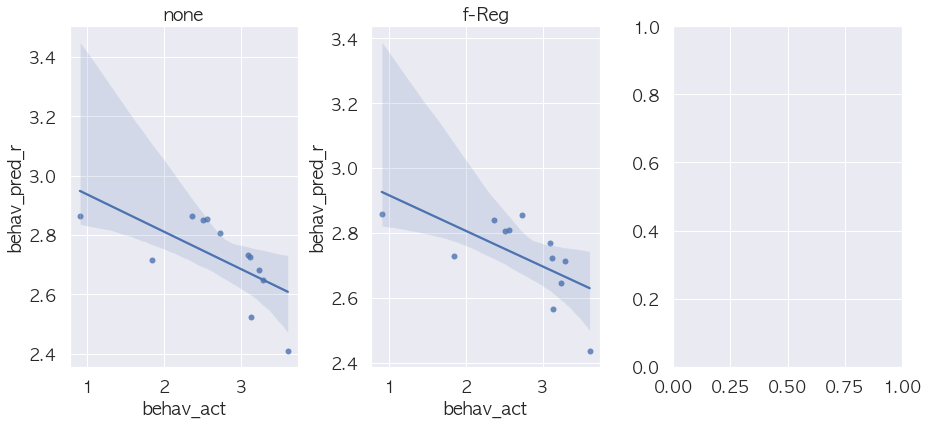

In [115]:
fig, axes = plt.subplots(1,3, figsize = [13,6])
for idx, name in enumerate(fs_method):
    tmp_df= fs_results.loc[fs_results['fs_method'] == name, ['behav_act', 'behav_pred_r']]
    sns.regplot(x='behav_act', y='behav_pred_r', data=tmp_df, ax = axes[idx]);
    axes[idx].set_title(('%s' % name))
plt.tight_layout()
plt.show()

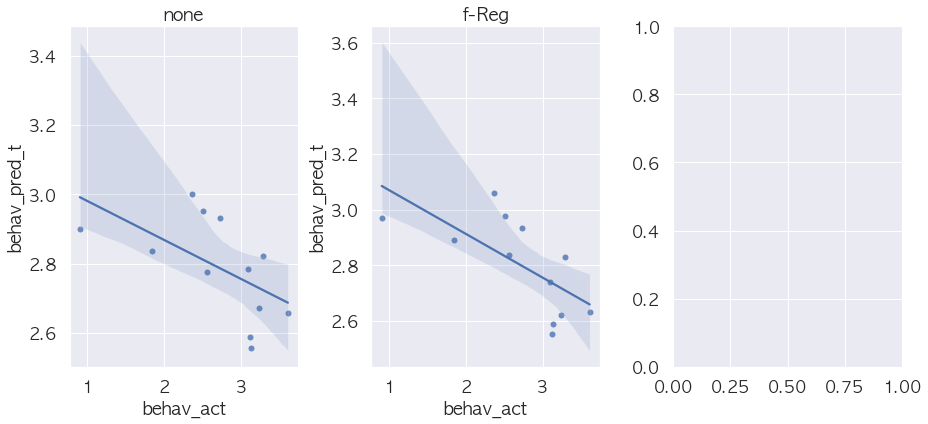

In [116]:
fig, axes = plt.subplots(1,3, figsize = [13,6])
for idx, name in enumerate(fs_method):
    tmp_df= fs_results.loc[fs_results['fs_method'] == name, ['behav_act', 'behav_pred_t']]
    sns.regplot(x='behav_act', y='behav_pred_t', data=tmp_df, ax = axes[idx]);
    axes[idx].set_title(('%s' % name))
plt.tight_layout()
plt.show()

* Model이 제대로 작동하지 않는다. feature 차원에 비해 지나치게 부족한 case수에 의한 것으로 추정된다.

## CPM

* 데이터 간 공변성, 다차원, 적은 case 수를 고려, PLSR 기법을 다시 활용한다. 

In [117]:
# import module
from sklearn.cross_decomposition import PLSRegression

from sklearn.linear_model import LinearRegression, BayesianRidge, Ridge, Lasso, BayesianRidge
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import KFold, LeaveOneOut, GridSearchCV
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error


### PLSR Optimization

In [118]:
def optimise_pls_cv(X, y, n_comp):
    # Define PLS object
    pls = PLSRegression(n_components=n_comp)

    # Cross-validation
    y_cv = cross_val_predict(pls, X, y, cv=12)

    # Calculate scores
    r2 = r2_score(y, y_cv)
    mse = mean_squared_error(y, y_cv)
    rpd = y.std()/np.sqrt(mse)
    
    return (y_cv, r2, mse, rpd)

def pick_nc(vals1, vals2, vals3, ylabel1, ylabel2, ylabel3, objective1, objective2, objective3):
    if objective1 == 'min':
        idx = np.argmin(vals1)
    else:
        idx = np.argmax(vals1)
    
    if objective2 == 'min':
        idx = np.argmin(vals2)
    else:
        idx = np.argmax(vals2)

    if objective3=='min':
        idx = np.argmin(vals3)
    else:
        idx = np.argmax(vals3)
        
    nc = xticks[idx]
    return nc
        

# Plot the mses
def plot_metrics(vals1, vals2, vals3, ylabel1, ylabel2, ylabel3, objective1, objective2, objective3):
    with plt.style.context('ggplot'):
        plt.subplot(1,3,1)
        plt.plot(xticks, np.array(vals1), '-v', color='blue', mfc='blue')
        if objective1=='min':
            idx = np.argmin(vals1)
        else:
            idx = np.argmax(vals1)
        plt.plot(xticks[idx], np.array(vals1)[idx], 'P', ms=10, mfc='red')
        plt.xlabel('Number of PLS components')
        plt.xticks = xticks
        plt.ylabel(ylabel1)
        plt.title('PLS - nComp %d' % xticks[idx])
                                           
        plt.subplot(1,3,2)
        plt.plot(xticks, np.array(vals2), '-v', color='blue', mfc='blue')
        if objective2=='min':
            idx = np.argmin(vals2)
        else:
            idx = np.argmax(vals2)
        plt.plot(xticks[idx], np.array(vals2)[idx], 'P', ms=10, mfc='red')
        plt.xlabel('Number of PLS components')
        plt.xticks = xticks
        plt.ylabel(ylabel2)
        plt.title('PLS - nComp %d' % xticks[idx])
                                           
        plt.subplot(1,3,3)
        plt.plot(xticks, np.array(vals3), '-v', color='blue', mfc='blue')
        if objective3=='min':
            idx = np.argmin(vals3)
        else:
            idx = np.argmax(vals3)
        plt.plot(xticks[idx], np.array(vals3)[idx], 'P', ms=10, mfc='red')
        plt.xlabel('Number of PLS components')
        plt.xticks = xticks
        plt.ylabel(ylabel3)
        plt.title('PLS - Comp %d' % xticks[idx])
        
        nc = xticks[idx]
        
        return nc
    plt.show()

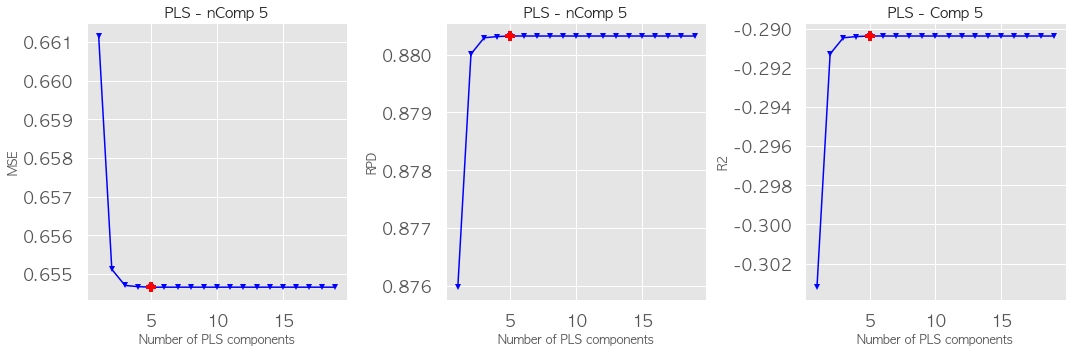


Rest-sFC / ncomp: 5


In [119]:
x_targ = np.array(df_target_r.loc[:, 1:])
y_targ = np.array(df_label.loc[:,'dprime'])
                  
# test with 20 components
r2s_r = []; mses_r = []; rpds_r = [];
xticks = np.arange(1, 20)
for n_comp in xticks:
    y_cv, r2, mse, rpd = optimise_pls_cv(x_targ, y_targ, n_comp)
    r2s_r.append(r2)
    mses_r.append(mse)
    rpds_r.append(rpd)
    
plt.figure(figsize=(15,5))
nc=plot_metrics(mses_r, rpds_r, r2s_r, 'MSE', 'RPD', 'R2', 'min', 'max', 'max')
plt.tight_layout()
plt.show()
print("\nRest-sFC", "/", "ncomp:", nc)
nc_r = nc


### Model Selection

In [120]:
Pls = PLSRegression(n_components=nc_r)
Ridge = Ridge()
Lasso = Lasso()
SVR = LinearSVR()
# Linear = LinearRegression()
# bRdige = BayesianRidge()
# Tree = DecisionTreeRegressor()

Model_list = [Pls, Ridge, Lasso, SVR]

In [121]:
def simple_fit(model, X_train, y_train):
    
    cv = KFold(n_splits = 10, random_state = 0, shuffle=True)
    y_pred = cross_val_predict(model, X_train, y_train, cv=cv)
    train_mse = mean_squared_error(y_train, y_pred)
    train_rmse = mean_squared_error(y_train, y_pred)**0.5
    train_mape = mean_absolute_percentage_error(y_train, y_pred)
    train_r2 = r2_score(y_train, y_pred)

    return y_pred.flatten(), train_mse, train_rmse, train_mape, train_r2

In [122]:
ms_df = pd.DataFrame(columns=[
                     'Model', 'MSE', 'RMSE', 'MAPE', 'R2', 'r', 'r_p'])

x_targ = df_target_r.loc[:, 1:]
y_targ = np.array(df_label.loc[:,'dprime'])

i = 0
for model in Model_list:
    i += 1
    print(model)
    y_pred, train_mse, train_rmse, train_mape, train_r2  = simple_fit(model, x_targ, y_targ)
    
    tmp_corr = pg.corr(y_targ, y_pred)
    
    

    ms_tmp = {'Model': str(model),
              'MSE': train_mse,
              'RMSE': train_rmse,
              'MAPE': train_mape ,
              'R2': train_r2 , 
              'r': tmp_corr['r'][0],
              'r_p': tmp_corr['p-val'][0]}
    ms_df = ms_df.append(ms_tmp, ignore_index=True)

PLSRegression(n_components=5)
Ridge()
Lasso()
LinearSVR()


In [123]:
ms_df

Model       MSE      RMSE      MAPE        R2  \
0  PLSRegression(n_components=5)  0.628639  0.792868  0.346103 -0.239101   
1                        Ridge()  0.632259  0.795147  0.346164 -0.246237   
2                        Lasso()  0.571209  0.755784  0.326911 -0.125903   
3                    LinearSVR()  0.556724  0.746140  0.290100 -0.097351   

          r       r_p  
0 -0.560069  0.058245  
1 -0.575734  0.050122  
2 -0.652141  0.021549  
3  0.147619  0.647070

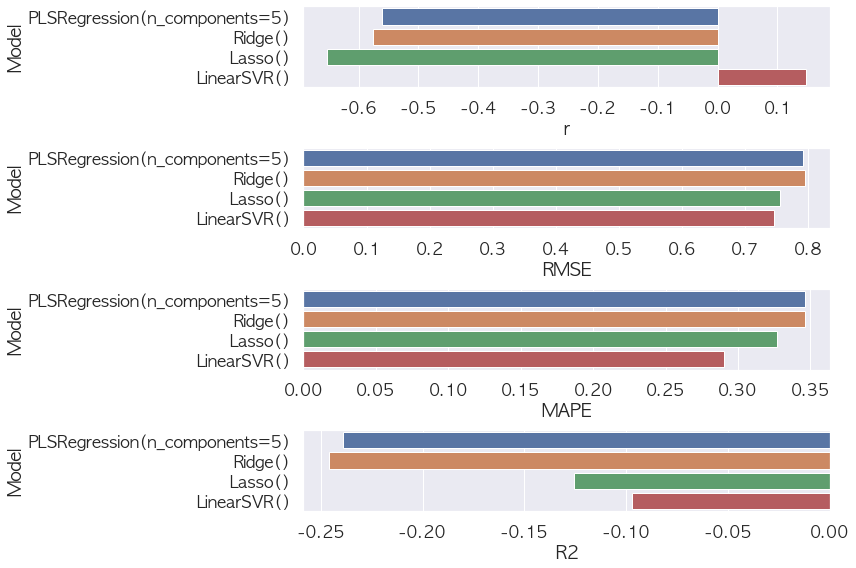

In [124]:
fig, axes = plt.subplots(4,1, figsize = [12,8])
sns.barplot(data=ms_df, y='Model', x ='r', ax = axes[0])
sns.barplot(data=ms_df, y='Model', x ='RMSE', ax = axes[1])
sns.barplot(data=ms_df, y='Model', x ='MAPE', ax = axes[2])
sns.barplot(data=ms_df, y='Model', x ='R2', ax = axes[3])
plt.tight_layout()
plt.show()

### Modeling

In [125]:
b_type = ['dprime']
fs_method = ['f-Reg']

Pls = PLSRegression(n_components=nc_r)
SVR = LinearSVR()
Model_list = [Pls, SVR]

fs_results = [];
x_model = [];
x_model_comp = [];
x_btype = [];
x_fs = [];
x_tSn = [];
x_tSn_act = [];
x_tSn_r_pred = [];
x_nFeature = [];

for m_idx , m_name in enumerate(Model_list):

    for b_idx , b_name in enumerate(b_type):

        for fs_idx, fs_name in enumerate(fs_method):

            print("%d. %s, %s, %s processing ----------------------------\n\n" % (fs_idx+1, m_name, b_name, fs_name))
            for idx, this_sub in enumerate(subj_idx):

                # subject index
                train_subj = deepcopy(subj_idx)
                train_subj.remove(this_sub)
                test_subj = this_sub                                   

                # prepare data             
                X_train_r = df_target_r.loc[df_target_r['sn'] != test_subj, 1:]
                y_train = df_label.loc[df_label['sn'] != test_subj, 'dprime']
                X_test_r = df_target_r.loc[df_target_r['sn'] == test_subj, 1:]
                y_test = df_label.loc[df_label['sn'] == test_subj, 'dprime']

                # feature scaling 
                scaler = StandardScaler()
                targ_col = X_train_r.columns.values
                X_train_r = scaler.fit_transform(X_train_r)
                X_train_r = pd.DataFrame(X_train_r)
                X_train_r.columns = targ_col
                X_test_r = scaler.transform(X_test_r)
                X_test_r = pd.DataFrame(X_test_r)
                X_test_r.columns = targ_col

                # feature selection
                if fs_name == 'none':

                    X_train_r_fs = np.array(X_train_r)
                    X_test_r_fs = np.array(X_test_r)
                    y_train_fs = np.array(y_train)
                    y_test_fs = np.array(y_test)

                elif fs_name == 'f-Reg':

                    Threshold = 0.05
                    selector_freg=SelectKBest(f_regression, k='all')
                    selector_freg.fit(X_train_r, y_train)
                    is_support_freg = selector_freg.pvalues_ < Threshold

                    X_train_r_fs = np.array(X_train_r[X_train_r.columns[is_support_freg].values])
                    X_test_r_fs = np.array(X_test_r[X_test_r.columns[is_support_freg].values])
                    y_train_fs = np.array(y_train)
                    y_test_fs = np.array(y_test)

                # PLSR optimization
                r2s_r = []; mses_r = []; rpds_r = [];
                xticks = np.arange(1, 10)
                for n_comp in xticks:
                    y_cv, r2, mse, rpd = optimise_pls_cv(x_targ, y_targ, n_comp)
                    r2s_r.append(r2)
                    mses_r.append(mse)
                    rpds_r.append(rpd)
                nc = pick_nc(mses_r, rpds_r, r2s_r, 'MSE', 'RPD', 'R2', 'min', 'max', 'max')

                # Model Fitting & Test
                # model_r = PLSRegression(n_components=nc)
                model_r = m_name
                model_r.fit(X_train_r_fs, y_train_fs)
                y_pred_r = model_r.predict(X_test_r_fs) 


                # saving results
                x_model.append(m_name)
                x_model_comp.append(nc)
                x_btype.append(b_name)
                x_fs.append(fs_name)
                x_tSn.append(this_sub)
                x_tSn_act.append(y_test_fs[0]);
                x_tSn_r_pred.append(y_pred_r[0]);        
                x_nFeature.append(X_train_r_fs.shape[1])

            print("%d. %s, %s, %s done ----------------------------\n\n" % (fs_idx+1, m_name, b_name, fs_name))

fs_results = pd.DataFrame({'model': x_model,
                           'mComp': x_model_comp,
                           'ability': x_btype,
                           'fs': x_fs,
                           'nFeature': x_nFeature,
                           'tSN': x_tSn,
                           'behav_act': x_tSn_act,                            
                           'behav_pred': x_tSn_r_pred})

1. PLSRegression(n_components=5), dprime, f-Reg processing ----------------------------


1. PLSRegression(n_components=5), dprime, f-Reg done ----------------------------


1. LinearSVR(), dprime, f-Reg processing ----------------------------


1. LinearSVR(), dprime, f-Reg done ----------------------------




In [126]:
fs_results

model  mComp ability     fs  nFeature  tSN  \
0   PLSRegression(n_components=5)      5  dprime  f-Reg      1500    2   
1   PLSRegression(n_components=5)      5  dprime  f-Reg      1711    3   
2   PLSRegression(n_components=5)      5  dprime  f-Reg      1830    4   
3   PLSRegression(n_components=5)      5  dprime  f-Reg      1711    5   
4   PLSRegression(n_components=5)      5  dprime  f-Reg      1530    6   
5   PLSRegression(n_components=5)      5  dprime  f-Reg      1718    7   
6   PLSRegression(n_components=5)      5  dprime  f-Reg      1627    8   
7   PLSRegression(n_components=5)      5  dprime  f-Reg      1561    9   
8   PLSRegression(n_components=5)      5  dprime  f-Reg      1588   10   
9   PLSRegression(n_components=5)      5  dprime  f-Reg      1599   11   
10  PLSRegression(n_components=5)      5  dprime  f-Reg      1660   12   
11  PLSRegression(n_components=5)      5  dprime  f-Reg      1344   13   
12                    LinearSVR()      5  dprime  f-Reg      1500    2   
13                    LinearSVR()      5  dprime  f-Reg      1711    3   
14                    LinearSVR()      5  dprime  f-Reg      1830    4   
15                    LinearSVR()      5  dprime  f-Reg      1711    5   
16                    LinearSVR()      5  dprime  f-Reg      1530    6   
17                    LinearSVR()      5  dprime  f-Reg      1718    7   
18                    LinearSVR()      5  dprime  f-Reg      1627    8   
19                    LinearSVR()      5  dprime  f-Reg      1561    9   
20                    LinearSVR()      5  dprime  f-Reg      1588   10   
21                    LinearSVR()      5  dprime  f-Reg      1599   11   
22                    LinearSVR()      5  dprime  f-Reg      1660   12   
23                    LinearSVR()      5  dprime  f-Reg      1344   13   

    behav_act            behav_pred  
0    1.850727  [2.7309806312445595]  
1    2.504125  [2.8053584457799885]  
2    3.609470  [2.4364219634664734]  
3    3.132076   [2.567438155339094]  
4    3.292870   [2.715447530804656]  
5    2.726137  [2.8544815741195495]  
6    3.236010  [2.6475384080560858]  
7    3.096713  [2.7692586088286593]  
8    3.122660   [2.724660805786655]  
9    2.559771   [2.810584657598049]  
10   2.366633  [2.8402911175311654]  
11   0.908840   [2.859097938324951]  
12   1.850727              2.730603  
13   2.504125              2.805019  
14   3.609470              2.435819  
15   3.132076              2.566718  
16   3.292870              2.715132  
17   2.726137              2.853996  
18   3.236010              2.647228  
19   3.096713              2.768777  
20   3.122660              2.724315  
21   2.559771              2.810391  
22   2.366633              2.839932  
23   0.908840              2.858604

In [127]:
tmp_df_1 = fs_results.loc[fs_results['model'] == fs_results.model[0], 
                          ['behav_act', 'behav_pred']]
tmp_df_1.behav_pred = np.concatenate(tmp_df_1.behav_pred.values)
tmp_df_2 = fs_results.loc[fs_results['model'] == fs_results.model[12], 
                          ['behav_act', 'behav_pred']]
tmp_df_2.behav_pred = tmp_df_2.behav_pred.astype(float)

In [128]:
tmp_corr_r = pg.corr(tmp_df_1.behav_act, tmp_df_1.behav_pred)    
rmse_r = mean_squared_error(tmp_df_1.behav_act, tmp_df_1.behav_pred)**0.5
mape_r = mean_absolute_percentage_error(tmp_df_1.behav_act, tmp_df_1.behav_pred)
print(rmse_r, mape_r)

0.7965044427366488 0.3485560466307322


In [129]:
tmp_corr_r

n         r           CI95%     p-val   BF10     power
pearson  12 -0.642623  [-0.89, -0.11]  0.024217  3.459  0.657718

In [130]:
tmp_corr_r = pg.corr(tmp_df_2.behav_act, tmp_df_2.behav_pred)    
rmse_r = mean_squared_error(tmp_df_2.behav_act, tmp_df_2.behav_pred)**0.5
mape_r = mean_absolute_percentage_error(tmp_df_2.behav_act, tmp_df_2.behav_pred)
print(rmse_r, mape_r)

0.7965143753732008 0.34851986321714223


In [131]:
tmp_corr_r

n         r           CI95%     p-val   BF10     power
pearson  12 -0.642387  [-0.89, -0.11]  0.024286  3.451  0.657264

* 여전히 제대로 적합되지 않는다. 케이스 수를 더 확보할 필요가 있다.

## Relationship beyween sFC and susATT

* rest, task sFC의 Network별 평균 FC value와 Sustained Attetion d-prime 간의 관계를 확인한다.
* 적은 케이스 수를 고려, skipped correlation으로 robust correlaton을 확인한다.

In [67]:
edge_dat = pd.read_csv('%s/shen_edge_info.csv' % (kbri_dir))
net_list = ['Medial frontal', 'Fronto Parietal', 
            'Default Mode', 'Subcortical-cereb', 
            'Motor', 'Visual I', 'Visual II', 
            'Visual Association']

In [68]:
df_target_t = task_df.reset_index()
df_target_r = rest_df.reset_index()
df_label = behav_df

### Sustained Attention & Rest sFC

In [69]:
X_df = df_target_r.loc[:, 1:]
y_df = df_label.loc[:, 'dprime']

In [70]:
X_df = pd.concat([pd.DataFrame(edge_dat['net']), 
           X_df.T.reset_index(drop=True)], axis=1).T

In [71]:
X_df_1 = X_df.loc[0:, X_df.loc['net',:] == 1] 
X_df_2 = X_df.loc[0:, X_df.loc['net',:] == 2]
X_df_3 = X_df.loc[0:, X_df.loc['net',:] == 3]
X_df_4 = X_df.loc[0:, X_df.loc['net',:] == 4]
X_df_5 = X_df.loc[0:, X_df.loc['net',:] == 5]
X_df_6 = X_df.loc[0:, X_df.loc['net',:] == 6]
X_df_7 = X_df.loc[0:, X_df.loc['net',:] == 7]
X_df_8 = X_df.loc[0:, X_df.loc['net',:] == 8]

In [74]:
res = pd.concat([pg.corr(X_df_1.mean(axis=1), y_df, method='skipped'), pg.corr(X_df_2.mean(axis=1), y_df, method='skipped'),
           pg.corr(X_df_3.mean(axis=1), y_df, method='skipped'), pg.corr(X_df_4.mean(axis=1), y_df, method='skipped'),
           pg.corr(X_df_5.mean(axis=1), y_df, method='skipped'), pg.corr(X_df_6.mean(axis=1), y_df, method='skipped'),
           pg.corr(X_df_7.mean(axis=1), y_df, method='skipped'), pg.corr(X_df_8.mean(axis=1), y_df, method='skipped')]).T
res.columns = [net_list[0], net_list[1], net_list[2], net_list[3],
              net_list[4], net_list[5], net_list[6], net_list[7]]
res.T

n outliers         r          CI95%     p-val     power
Medial frontal      12        1 -0.009091  [-0.61, 0.59]  0.978837  0.048958
Fronto Parietal     12        1  0.127273  [-0.51, 0.68]  0.709215  0.065344
Default Mode        12        1 -0.236364  [-0.73, 0.42]  0.484091  0.108402
Subcortical-cereb   12        1  0.181818   [-0.47, 0.7]  0.592615  0.083179
Motor               12        1 -0.109091  [-0.67, 0.53]  0.749509   0.06091
Visual I            12        1 -0.163636   [-0.7, 0.48]  0.630685  0.076453
Visual II           12        1 -0.018182  [-0.61, 0.59]  0.957685  0.049205
Visual Association  12        1  0.672727   [0.12, 0.91]  0.023313  0.667365

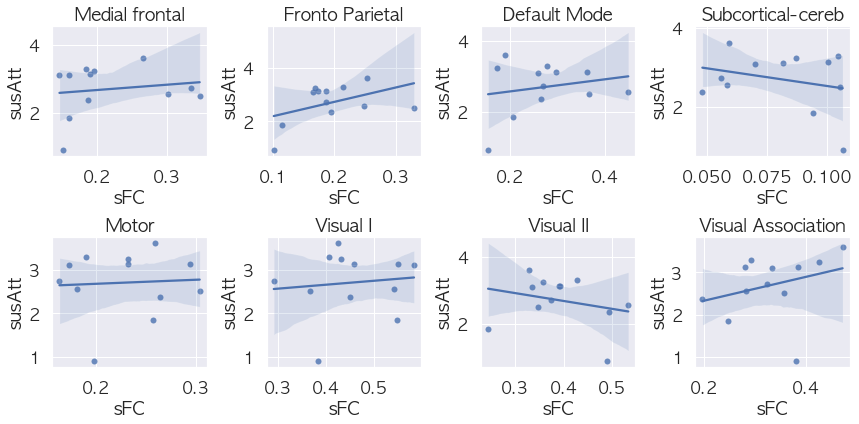

In [75]:
ax_list = [];
for i in range(2):
    for j in range(4):
        ax_list.append([int(i),int(j)])

fig, axes = plt.subplots(2,4, figsize = [12,6])
for idx, name in enumerate(net_list):
    tmp_x = eval(('X_df_%d' % (idx+1))).copy()
    tmp_df = pd.concat([tmp_x.mean(axis=1), y_df], axis = 1)
    tmp_df.columns = ['sFC', 'susAtt']
    g=sns.regplot(x='sFC', y='susAtt', data=tmp_df, ax = axes[ax_list[idx][0], ax_list[idx][1]]);
    axes[ax_list[idx][0], ax_list[idx][1]].set_title(('%s' % name))
plt.tight_layout()
plt.show()

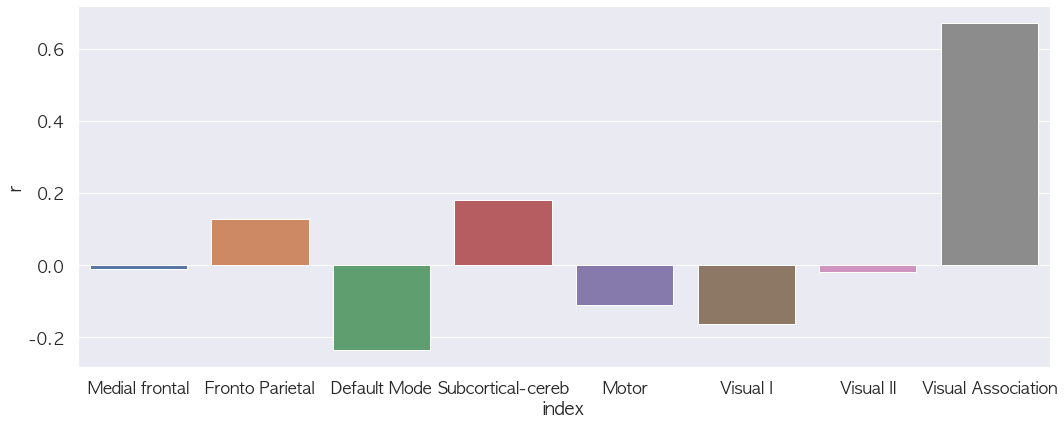

In [76]:
plt.subplots(figsize=[15,6])
sns.barplot(data=res.T.reset_index(), x='index', y='r')
plt.tight_layout()
plt.show()

* coefficient 수치만 판단하면 Visual Association의 영향이 큰 것으로 보인다.
* 적은 케이스로 인해 통계적으로 결과를 보증할 수 없다. 더 많은 케이스를 포함한 분석이 필요하다.

### Sustained Attention & task sFC

In [55]:
X_df = df_target_t.loc[:, 1:]
y_df = df_label.loc[:, 'dprime']

In [56]:
X_df = pd.concat([pd.DataFrame(edge_dat['net']), 
           X_df.T.reset_index(drop=True)], axis=1).T
X_df_1 = X_df.loc[0:, X_df.loc['net',:] == 1] 
X_df_2 = X_df.loc[0:, X_df.loc['net',:] == 2]
X_df_3 = X_df.loc[0:, X_df.loc['net',:] == 3]
X_df_4 = X_df.loc[0:, X_df.loc['net',:] == 4]
X_df_5 = X_df.loc[0:, X_df.loc['net',:] == 5]
X_df_6 = X_df.loc[0:, X_df.loc['net',:] == 6]
X_df_7 = X_df.loc[0:, X_df.loc['net',:] == 7]
X_df_8 = X_df.loc[0:, X_df.loc['net',:] == 8]

In [64]:
res = pd.concat([pg.corr(X_df_1.mean(axis=1), y_df, method='skipped'), pg.corr(X_df_2.mean(axis=1), y_df, method='skipped'),
           pg.corr(X_df_3.mean(axis=1), y_df, method='skipped'), pg.corr(X_df_4.mean(axis=1), y_df, method='skipped'),
           pg.corr(X_df_5.mean(axis=1), y_df, method='skipped'), pg.corr(X_df_6.mean(axis=1), y_df, method='skipped'),
           pg.corr(X_df_7.mean(axis=1), y_df, method='skipped'), pg.corr(X_df_8.mean(axis=1), y_df, method='skipped')]).T
res.columns = [net_list[0], net_list[1], net_list[2], net_list[3],
              net_list[4], net_list[5], net_list[6], net_list[7]]
res.T

n outliers         r          CI95%     p-val     power
Medial frontal      12        1 -0.036364  [-0.62, 0.58]  0.915468  0.050195
Fronto Parietal     12        1  0.136364   [-0.5, 0.68]  0.689309  0.067836
Default Mode        12        1       0.1  [-0.53, 0.66]  0.769875  0.058964
Subcortical-cereb   12        1  0.336364  [-0.33, 0.78]  0.311824  0.176936
Motor               12        1 -0.081818  [-0.65, 0.54]   0.81099  0.055601
Visual I            12        1 -0.372727  [-0.79, 0.29]  0.258926  0.210019
Visual II           12        1       0.2  [-0.45, 0.71]  0.555445  0.090724
Visual Association  12        1  0.354545  [-0.31, 0.79]  0.284693  0.192892

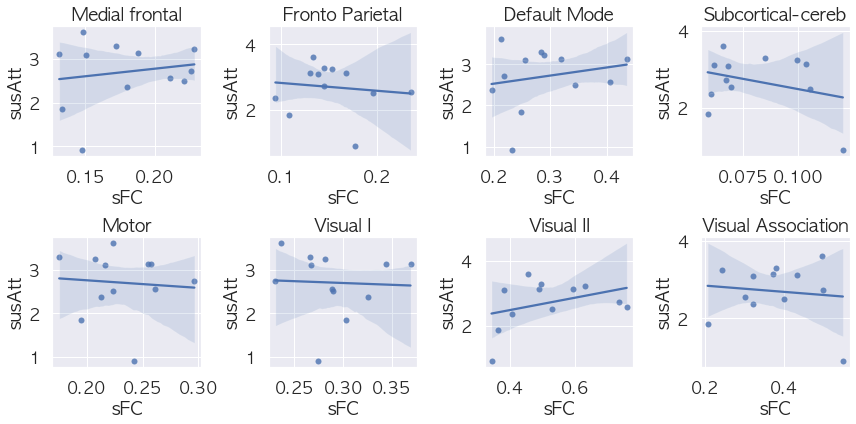

In [65]:
ax_list = [];
for i in range(2):
    for j in range(4):
        ax_list.append([int(i),int(j)])

fig, axes = plt.subplots(2,4, figsize = [12,6])
for idx, name in enumerate(net_list):
    tmp_x = eval(('X_df_%d' % (idx+1))).copy()
    tmp_df = pd.concat([tmp_x.mean(axis=1), y_df], axis = 1)
    tmp_df.columns = ['sFC', 'susAtt']
    g=sns.regplot(x='sFC', y='susAtt', data=tmp_df, ax = axes[ax_list[idx][0], ax_list[idx][1]]);
    axes[ax_list[idx][0], ax_list[idx][1]].set_title(('%s' % name))
plt.tight_layout()
plt.show()

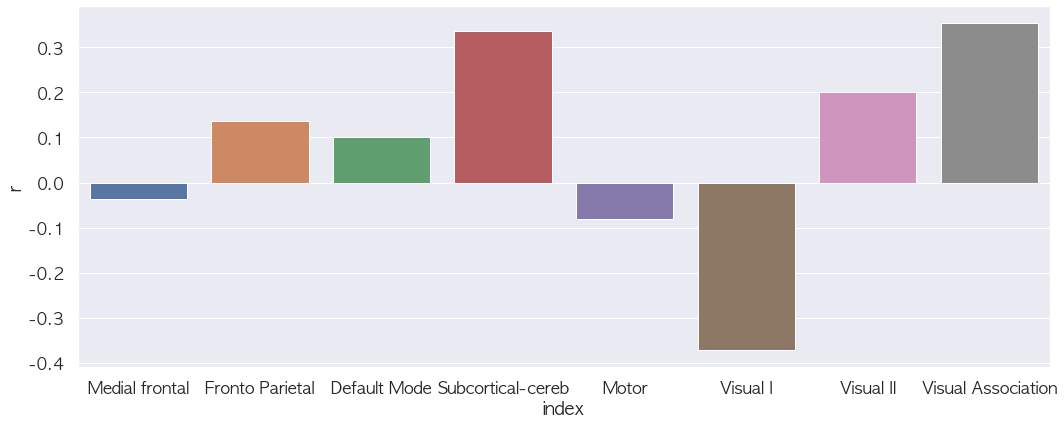

In [66]:
plt.subplots(figsize=[15,6])
sns.barplot(data=res.T.reset_index(), x='index', y='r')
plt.tight_layout()
plt.show()

* 마찬가지로 적은 케이스로 인해 통계적으로 결과를 보증할 수 없다. 더 많은 케이스를 포함한 분석이 필요하다.